In [2]:
import argparse
import json
import math
import os
import random
from time import time
import mlflow
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, f1_score
from collections import defaultdict

# import pytrec_eval
import torch
from torch.nn import CrossEntropyLoss, BCEWithLogitsLoss
from torch.utils.data import DataLoader, RandomSampler
from transformers import BertTokenizer, BertForSequenceClassification, BertConfig, AutoTokenizer
from transformers import AdamW, get_linear_schedule_with_warmup
from accelerate import Accelerator
from copy import deepcopy

torch.backends.cuda.matmul.allow_tf32 = True

from watchog.dataset import (
    # collate_fn,
    TURLColTypeTablewiseDataset,
    TURLRelExtTablewiseDataset,
    SatoCVTablewiseDataset,
    ColPoplTablewiseDataset
)

from watchog.dataset import TableDataset, SupCLTableDataset, SemtableCVTablewiseDataset, GittablesColwiseDataset, GittablesCVTablewiseDataset
from watchog.model import BertMultiPairPooler, BertForMultiOutputClassification, BertForMultiOutputClassificationColPopl
from watchog.model import SupCLforTable, UnsupCLforTable, lm_mp
from watchog.utils import load_checkpoint, f1_score_multilabel, collate_fn, get_col_pred, ColPoplEvaluator
from watchog.utils import task_num_class_dict
from accelerate import DistributedDataParallelKwargs
import wandb

[nltk_data] Downloading package punkt to /home/zhihao/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/zhihao/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    parser = argparse.ArgumentParser()
    parser.add_argument("--wandb", type=bool, default=False)
    parser.add_argument("--model", type=str, default="Watchog")
    parser.add_argument("--unlabeled_train_only", type=bool, default=False)
    parser.add_argument("--context_encoding_type", type=str, default="v0")
    parser.add_argument("--pool_version", type=str, default="v0.2")
    parser.add_argument("--random_sample", type=bool, default=False)
    parser.add_argument("--comment", type=str, default="debug", help="to distinguish the runs")
    parser.add_argument(
        "--shortcut_name",
        default="bert-base-uncased",
        type=str,
        help="Huggingface model shortcut name ",
    )
    parser.add_argument(
        "--max_length",
        default=64,
        type=int,
        help=
        "The maximum total input sequence length after tokenization. Sequences longer "
        "than this will be truncated, sequences shorter will be padded.",
    )
    parser.add_argument(
        "--adaptive_max_length",
        default=False,
        type=bool,
    )    
    parser.add_argument(
        "--max_num_col",
        default=8,
        type=int,
    )   

    parser.add_argument(
        "--batch_size",
        default=16,
        type=int,
        help="Batch size",
    )
    parser.add_argument(
        "--epoch",
        default=1,
        type=int,
        help="Number of epochs for training",
    )
    parser.add_argument(
        "--random_seed",
        default=4649,
        type=int,
        help="Random seed",
    )
    
    parser.add_argument(
        "--train_n_seed_cols",
        default=-1,
        type=int,
        help="number of seeding columns in training",
    )

    parser.add_argument(
        "--num_classes",
        default=78,
        type=int,
        help="Number of classes",
    )
    parser.add_argument("--multi_gpu",
                        action="store_true",
                        default=False,
                        help="Use multiple GPU")
    parser.add_argument("--fp16",
                        action="store_true",
                        default=False,
                        help="Use FP16")
    parser.add_argument("--warmup",
                        type=float,
                        default=0.,
                        help="Warmup ratio")
    parser.add_argument("--lr", type=float, default=5e-5, help="Learning rate")
    parser.add_argument("--task",
                        type=str,
                        default='gt-semtab22-dbpedia-all0',
                        choices=[
                            "sato0", "sato1", "sato2", "sato3", "sato4",
                            "msato0", "msato1", "msato2", "msato3", "msato4",
                            "gt-dbpedia0", "gt-dbpedia1", "gt-dbpedia2", "gt-dbpedia3", "gt-dbpedia4",
                            "gt-dbpedia-all0", "gt-dbpedia-all1", "gt-dbpedia-all2", "gt-dbpedia-all3", "gt-dbpedia-all4",
                            "gt-schema-all0", "gt-schema-all1", "gt-schema-all2", "gt-schema-all3", "gt-schema-all4",
                            "gt-semtab22-dbpedia", "gt-semtab22-dbpedia0", "gt-semtab22-dbpedia1", "gt-semtab22-dbpedia2", "gt-semtab22-dbpedia3", "gt-semtab22-dbpedia4",
                            "gt-semtab22-dbpedia-all", "gt-semtab22-dbpedia-all0", "gt-semtab22-dbpedia-all1", "gt-semtab22-dbpedia-all2", "gt-semtab22-dbpedia-all3", "gt-semtab22-dbpedia-all4",
                            "gt-semtab22-schema-class-all", "gt-semtab22-schema-property-all",
                            "turl", "turl-re", "col-popl-1", "col-popl-2", "col-popl-3", "row-popl",
                            "col-popl-turl-0", "col-popl-turl-1", "col-popl-turl-2",
                            "col-popl-turl-mdonly-0", "col-popl-turl-mdonly-1", "col-popl-turl-mdonly-2"
                        ],
                        help="Task names}")
    parser.add_argument("--colpair",
                        action="store_true",
                        help="Use column pair embedding")
    parser.add_argument("--metadata",
                        action="store_true",
                        help="Use column header metadata")
    parser.add_argument("--from_scratch",
                        action="store_true",
                        help="Training from scratch")
    parser.add_argument("--cl_tag",
                        type=str,
                        default="wikitables/simclr/bert_100000_10_32_256_5e-05_sample_row4,sample_row4_tfidf_entity_column_0.05_0_last.pt",
                        help="path to the pre-trained file")
    parser.add_argument("--dropout_prob",
                        type=float,
                        default=0.5)
    parser.add_argument("--eval_test",
                        action="store_true",
                        help="evaluate on testset and do not save the model file")
    parser.add_argument("--small_tag",
                        type=str,
                        default="semi1",
                        help="e.g., by_table_t5_v1")
    parser.add_argument("--data_path",
                        type=str,
                        default="/data/zhihao/TU/")
    parser.add_argument("--pretrained_ckpt_path",
                        type=str,
                        default="/data/zhihao/TU/Watchog/model/")    

    args = parser.parse_args([])
    task = args.task
    if args.small_tag != "":
        args.eval_test = True
    
    args.num_classes = task_num_class_dict[task]
    if args.colpair:
        assert "turl-re" == task, "colpair can be only used for Relation Extraction"
    if args.metadata:
        assert "turl-re" == task or "turl" == task, "metadata can be only used for TURL datasets"
    if "col-popl":
        # metrics = {
        #     "accuracy": CategoricalAccuracy(tie_break=True),
        # }
        if args.train_n_seed_cols != -1:
            if "col-popl" in task:
                assert args.train_n_seed_cols == int(task[-1]),  "# of seed columns must match"

    print("args={}".format(json.dumps(vars(args))))

    max_length = args.max_length
    batch_size = args.batch_size
    num_train_epochs = args.epoch

    shortcut_name = args.shortcut_name

    if args.colpair and args.metadata:
        taskname = "{}-colpair-metadata".format(task)
    elif args.colpair:
        taskname = "{}-colpair".format(task)
    elif args.metadata:
        taskname = "{}-metadata".format(task)
    elif args.train_n_seed_cols == -1 and 'popl' in task:
        taskname = "{}-mix".format(task)
    else:
        taskname = "".join(task)
    cv = int(task[-1])

    if args.from_scratch:
        if "gt" in task:
            tag_name = "{}/{}-{}-{}-pool{}-max_cols{}-rand{}-bs{}-ml{}-ne{}-do{}{}".format(
                taskname,  "{}-fromscratch".format(shortcut_name), args.small_tag, args.comment, args.pool_version, args.max_num_col, args.random_sample,
                batch_size, max_length, num_train_epochs, args.dropout_prob, 
                '-rs{}'.format(args.random_seed) if args.random_seed != 4649 else '')
        else:
            tag_name = "{}/{}-{}-{}-bs{}-ml{}-ne{}-do{}{}".format(
                taskname,  "{}-fromscratch".format(shortcut_name), args.small_tag, args.comment, 
                batch_size, max_length, num_train_epochs, args.dropout_prob, 
                '-rs{}'.format(args.random_seed) if args.random_seed != 4649 else '')
        
    else:
        if "gt" in task:
            tag_name = "{}/{}_{}-pool{}-max_cols{}-rand{}-bs{}-ml{}-ne{}-do{}{}".format(
                taskname, args.cl_tag.replace('/', '-'),  shortcut_name, args.small_tag, args.pool_version, args.max_num_col, args.random_sample,
                batch_size, max_length, num_train_epochs, args.dropout_prob,
                '-rs{}'.format(args.random_seed) if args.random_seed != 4649 else '')
        else:
            tag_name = "{}/{}_{}-{}-bs{}-ml{}-ne{}-do{}{}".format(
                taskname, args.cl_tag.replace('/', '-'),  shortcut_name, args.small_tag,
                batch_size, max_length, num_train_epochs, args.dropout_prob,
                '-rs{}'.format(args.random_seed) if args.random_seed != 4649 else '')

    # if args.eval_test:
    #     if args.small_tag != '':
    #         tag_name = tag_name.replace('outputs', 'small_outputs')
    #         tag_name += '-' + args.small_tag
    print(tag_name)
    file_path = os.path.join(args.data_path, "Watchog", "outputs", tag_name)

    dirpath = os.path.dirname(file_path)
    if not os.path.exists(dirpath):
        print("{} not exists. Created".format(dirpath))
        os.makedirs(dirpath)
    
    if args.fp16:
        torch.backends.cuda.matmul.allow_fp16_reduced_precision_reduction = True
        
      
        
    # accelerator = Accelerator(mixed_precision="no" if not args.fp16 else "fp16")   
    ddp_kwargs = DistributedDataParallelKwargs(find_unused_parameters=True)
    accelerator = Accelerator(mixed_precision="no" if not args.fp16 else "fp16", kwargs_handlers=[ddp_kwargs])

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    ckpt_path = os.path.join(args.pretrained_ckpt_path, args.cl_tag)
    # ckpt_path = '/efs/checkpoints/{}.pt'.format(args.cl_tag)
    ckpt = torch.load(ckpt_path, map_location=device)
    ckpt_hp = ckpt['hp']
    print(ckpt_hp)
 
    setattr(ckpt_hp, 'batch_size', args.batch_size)
    setattr(ckpt_hp, 'hidden_dropout_prob', args.dropout_prob)
    setattr(ckpt_hp, 'shortcut_name', args.shortcut_name)
    setattr(ckpt_hp, 'num_labels', args.num_classes)
    
    
    
    tokenizer = BertTokenizer.from_pretrained(shortcut_name)
    padder = collate_fn(tokenizer.pad_token_id)
    if task == "turl-re" and args.colpair:
        model = BertForMultiOutputClassification(ckpt_hp, device=device, lm=ckpt['hp'].lm, col_pair='Pair')
    elif "col-popl" in task:
        model = BertForMultiOutputClassificationColPopl(ckpt_hp, device=device, lm=ckpt['hp'].lm, n_seed_cols=int(task[i][-1]), cls_for_md="md" in task)
    else:
        model = BertForMultiOutputClassification(ckpt_hp, device=device, lm=ckpt['hp'].lm, version=args.pool_version)
        


args={"wandb": false, "model": "Watchog", "unlabeled_train_only": false, "context_encoding_type": "v0", "pool_version": "v0.2", "random_sample": false, "comment": "debug", "shortcut_name": "bert-base-uncased", "max_length": 64, "adaptive_max_length": false, "max_num_col": 8, "batch_size": 16, "epoch": 1, "random_seed": 4649, "train_n_seed_cols": -1, "num_classes": 101, "multi_gpu": false, "fp16": false, "warmup": 0.0, "lr": 5e-05, "task": "gt-semtab22-dbpedia-all0", "colpair": false, "metadata": false, "from_scratch": false, "cl_tag": "wikitables/simclr/bert_100000_10_32_256_5e-05_sample_row4,sample_row4_tfidf_entity_column_0.05_0_last.pt", "dropout_prob": 0.5, "eval_test": true, "small_tag": "semi1", "data_path": "/data/zhihao/TU/", "pretrained_ckpt_path": "/data/zhihao/TU/Watchog/model/"}
gt-semtab22-dbpedia-all0/wikitables-simclr-bert_100000_10_32_256_5e-05_sample_row4,sample_row4_tfidf_entity_column_0.05_0_last.pt_bert-base-uncased-poolsemi1-max_colsv0.2-rand8-bsFalse-ml16-ne64-do1

Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
/tmp/ipykernel_3877793/3515063068.py:214: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control o

Namespace(augment_op='sample_row4,sample_row4', batch_size=32, data_path='/data/zhihao/TU/TURL/', fp16=True, gpus='0', lm='bert', logdir='/data/zhihao/TU/Watchog/model/', lr=5e-05, max_len=256, mode='simclr', model='Watchog', n_epochs=10, pretrain_data='wikitables', pretrained_model_path='', projector=768, run_id=0, sample_meth='tfidf_entity', save_model=10, single_column=False, size=100000, table_order='column', temperature=0.05)


A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Pl

In [4]:
text = "BERT is a powerful language model."
tokenizer.tokenize(text)

['bert', 'is', 'a', 'powerful', 'language', 'model', '.']

In [5]:
from argparse import Namespace
import torch
import random
import pandas as pd
import numpy as np
import os
import pickle
import json
import re
import transformers
from torch.utils import data
from torch.nn.utils import rnn
from transformers import AutoTokenizer

from typing import List
from functools import reduce
import operator

from itertools import chain
import copy
class SingleColDataset(data.Dataset):
    def __init__(
            self,
            group_df,
            target_col_idx: int,
            tokenizer: AutoTokenizer,
            max_length: int = 64,
            device: torch.device = None,
            max_num_col=8,
            random_sample=False, # TODO
            train_only=True,
            context_encoding_type="v1",
            adaptive_max_length=False,
            ): # TODO: not used
        if device is None:
            device = torch.device('cpu')
        assert max_num_col >= 1, "max_num_col must be greater than 1"
        assert 512//max_num_col >= max_length  , "max_length cannot be smaller than 512//max_num_col"



        
        data_list = []
        


 
        
        # df.drop(df[(df['data'] == '') & (df['class_id'] == -1)].index, inplace=True)
        group_df.sort_values(by=['col_idx'], inplace=True)
        labeled_columns = group_df[group_df['class_id'] > -1]
        # if len(labeled_columns) > 1:
        #     print("Here")
        unlabeled_columns = group_df[group_df['class_id'] == -1]
        for idx in [target_col_idx]:
            token_ids_list = []
            target_column = labeled_columns.loc[idx]
            rest_columns = labeled_columns[labeled_columns.index != idx] # the rest of labeled columns
            # tokenize target column
            token_ids_list.append(tokenizer.encode(
            tokenizer.cls_token + " " + target_column["data"], add_special_tokens=False, max_length=max_length, truncation=True))
            # tokenize context
            unlabeled_columns = unlabeled_columns

            group_df = pd.concat([rest_columns, unlabeled_columns])
            group_df = group_df[: max_num_col-1] if not random_sample  else group_df.sample(min(max_num_col-1, len(group_df))) # TODO
            group_df.sort_values(by=['col_idx'], inplace=True)
            
            if adaptive_max_length and (len(group_df)+1) < max_num_col:
                cur_maxlen = 512 // (len(group_df)+1)
            else:
                cur_maxlen = max_length
                
            if context_encoding_type == "v0":
                token_ids_list += group_df["data"].apply(lambda x: tokenizer.encode(
                tokenizer.cls_token + " " + x, add_special_tokens=False, max_length=cur_maxlen, truncation=True)).tolist(
                )
            elif context_encoding_type == "v0.1": # only one cls token to separate context and target
                token_ids_list.append([tokenizer.cls_token_id])
                token_ids_list += group_df["data"].apply(lambda x: tokenizer.encode(
                " " + x, add_special_tokens=False, max_length=cur_maxlen-1, truncation=True)).tolist(
                )                    
            elif context_encoding_type == "v1":
                token_ids_list += group_df["data"].apply(lambda x: tokenizer.encode(
                tokenizer.sep_token + " " + x, add_special_tokens=False, max_length=cur_maxlen, truncation=True)).tolist(
                )                    
            elif context_encoding_type == "v1.1": # only one cls token to separate context and target
                token_ids_list.append([tokenizer.sep_token_id])
                token_ids_list += group_df["data"].apply(lambda x: tokenizer.encode(
                " " + x, add_special_tokens=False, max_length=cur_maxlen-1, truncation=True)).tolist(
                )   
            else:
                raise ValueError("context_encoding_type {} is not supported".format(context_encoding_type))
            token_ids = torch.LongTensor(reduce(operator.add,
                                                token_ids_list)).to(device)
            cls_index_list = [0] 
            for cls_index in cls_index_list:
                assert token_ids[
                    cls_index] == tokenizer.cls_token_id, "cls_indexes validation"
            cls_indexes = torch.LongTensor(cls_index_list).to(device)
            class_ids = torch.LongTensor([target_column["class_id"]]
                ).to(device)
            data_list.append(
                [0,
                len(group_df), token_ids, class_ids, cls_indexes])
        self.table_df = pd.DataFrame(data_list,
                                     columns=[
                                         "table_id", "num_col", "data_tensor",
                                         "label_tensor", "cls_indexes"
                                     ])
        """
        # NOTE: msato contains a small portion of single-col tables. keep it to be consistent.  
        if multicol_only:
            # Check
            num_all_tables = len(self.table_df)
            self.table_df = self.table_df[self.table_df["num_col"] > 1]
            assert len(self.table_df) == num_all_tables
        """

    def __len__(self):
        return len(self.table_df)

    def __getitem__(self, idx):
        return {
            "data": self.table_df.iloc[idx]["data_tensor"],
            "label": self.table_df.iloc[idx]["label_tensor"]
        }
        #"idx": torch.LongTensor([idx])}
        #"cls_indexes": self.table_df.iloc[idx]["cls_indexes"]}

In [5]:

base_dirpath = "/data/zhihao/TU/GitTables/semtab_gittables/2022/"
seperator = "semi1"
basename = seperator+"_cv_{}.csv"
df_list = []
filepath = os.path.join(base_dirpath, basename.format(cv))
df_test = pd.read_csv(filepath)

df_group_test = df_test.groupby("table_id")



df_list = []
for i in range(5):
    if i == cv:
        continue
    filepath = os.path.join(base_dirpath, basename.format(i))
    df_list.append(pd.read_csv(filepath))
df_train = pd.concat(df_list, axis=0)
df_group_train = df_train.groupby("table_id")

In [144]:
import json
import numpy as np

# Function to load confusion matrix from JSON file
# with open("/data/zhihao/TU/doduo/eval/sato0_mosato_bert_bert-base-uncased-bs16-ml-32__sato0-1.00=sato0.json", 'r') as f:
#     results = json.load(f)
with open(f"/data/zhihao/TU/Watchog/outputs/gt-semtab22-dbpedia-all{cv}/bert-base-uncased-fromscratch-semi1-pool@v0-context@v1-max_num_col@8-poolv0-max_cols8-randFalse-bs16-ml64-ne50-do0.1_eval.json", 'r') as f:
    results = json.load(f)

# labels_train = np.array(results['train']['tr_true_list'])
# preds_train = np.array(results['train']['tr_pred_list'])
# class_f1_train = np.array(results['train']['tr_class_f1'])

labels = np.array(results['f1_micro']['true_list'])
preds = np.array(results['f1_micro']['pred_list'])
class_f1 = np.array(results['f1_micro']['ts_class_f1'])
assert len(labels) == len(df_test["class_id"][df_test["class_id"]>-1])

In [33]:
import json
import numpy as np

# Function to load confusion matrix from JSON file
# with open("/data/zhihao/TU/doduo/eval/sato0_mosato_bert_bert-base-uncased-bs16-ml-32__sato0-1.00=sato0.json", 'r') as f:
#     results = json.load(f)
with open(f"/data/zhihao/TU/Watchog/outputs/gt-semtab22-dbpedia-all{cv}/bert-base-uncased-fromscratch-semi1-pool@v0-context@v1-max_num_col@8-poolv0-max_cols8-randFalse-bs16-ml64-ne50-do0.1_eval.json", 'r') as f:
    results = json.load(f)

# labels_train = np.array(results['train']['tr_true_list'])
# preds_train = np.array(results['train']['tr_pred_list'])
# class_f1_train = np.array(results['train']['tr_class_f1'])

labels = np.array(results['f1_micro']['true_list'])
preds = np.array(results['f1_micro']['pred_list'])
class_f1 = np.array(results['f1_micro']['ts_class_f1'])
assert len(labels) == len(df_test["class_id"][df_test["class_id"]>-1])

In [7]:
import json
import numpy as np

# Function to load confusion matrix from JSON file
# with open("/data/zhihao/TU/doduo/eval/sato0_mosato_bert_bert-base-uncased-bs16-ml-32__sato0-1.00=sato0.json", 'r') as f:
#     results = json.load(f)
with open(f"/data/zhihao/TU/Watchog/outputs/gt-semtab22-dbpedia-all{cv}/bert-base-uncased-fromscratch-semi1-pool@v0-max_num_col@1-poolv0-max_cols1-randFalse-bs16-ml64-ne50-do0.1_eval.json", 'r') as f:
    results = json.load(f)

# labels_train = np.array(results['train']['tr_true_list'])
# preds_train = np.array(results['train']['tr_pred_list'])
# class_f1_train = np.array(results['train']['tr_class_f1'])

labels_single = np.array(results['f1_micro']['true_list'])
preds_single = np.array(results['f1_micro']['pred_list'])
class_f1_single = np.array(results['f1_micro']['ts_class_f1'])
# assert len(labels) == len(df_test["class_id"][df_test["class_id"]>-1])

In [457]:
print(class_f1.mean(), class_f1_single.mean())

0.30538750303598283 0.2968195661092821


In [458]:
sum(class_f1_single>class_f1)

28

In [14]:
num = 0
wrong_num = 0
target_type = "price"
target_type_id = np.where(types==target_type )[0][0]
# print(class_f1[target_type_id],sum(preds[labels==target_type_id]==target_type_id))
print("================================")
for i, (index, group_df) in enumerate(df_group_test):
    if target_type in group_df["class"].values:
        if "Wuthering Heights" in " ".join(group_df["data"].values):
            break

In [12]:
num = 0
wrong_num = 0
target_type = "price"
target_type_id = np.where(types==target_type )[0][0]
print(class_f1[target_type_id],sum(preds[labels==target_type_id]==target_type_id))
print("================================")
for i, (index, group_df) in enumerate(df_group_test):
    if target_type in group_df["class"].values:
        if types[preds[labels==target_type_id]][num] == target_type:
            print(types[preds[labels==target_type_id]][num], "||",group_df[group_df["class_id"]>-1][["class", "data"]])
            wrong_num += 1
            print(group_df[group_df["class_id"]==-1][["class", "data"]])
            print("================================")
        
            if "Wuthering Heights" in " ".join(group_df["data"].values):
                break
        num += 1
        

NameError: name 'class_f1' is not defined

In [369]:
group_df["data"].values[0]

'Wuthering Heights;Jane Eyre;The Raven;Eleonora;Catweazle'

In [370]:
group_df_book = deepcopy(group_df)

In [286]:
num = 0
wrong_num = 0
target_type = "price"
target_type_id = np.where(types==target_type )[0][0]
print(class_f1[target_type_id],sum(preds[labels==target_type_id]==target_type_id))
print("================================")
for i, (index, group_df) in enumerate(df_group_test):
    if target_type in group_df["class"].values:
        if types[preds[labels==target_type_id]][num] != target_type:
            print(types[preds[labels==target_type_id]][num], "||",group_df[group_df["class_id"]>-1][["class", "data"]])
            wrong_num += 1
            print(group_df[group_df["class_id"]==-1][["class", "data"]])
            print("================================")
        num += 1
            # if "accessory_candle_tealight" in " ".join(group_df["data"].values):
            #     break
        

0.5 4
age ||       class                                               data
3305   date  2021-01-02;2020-12-26;2020-12-16;2020-12-02;20...
3308  price  42.493;31.765;38.265;38.053;25.769;34.784;35.8...
3310   note  Shell fuelsave;Emptied tank after 636 km;Bough...
     class                                               data
3304   NaN  1;2;3;4;5;6;7;8;9;10;11;12;13;14;15;16;17;18;1...
3306   NaN  168529.0;167994.0;167538.0;167034.0;166561.0;1...
3307   NaN  28.16;21.191;25.358;25.729;17.542;23.841;25.09...
3309   NaN  False;False;False;False;False;False;False;Fals...
3311   NaN  1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;...
3312   NaN  1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;...
weight ||       class                                data
3700  price  20.1;50.0;20.1;30.0;30.0;30.0;30.0
     class                                               data
3691   NaN                                      1;2;3;4;5;6;7
3692   NaN                                      2;2;2;3;3;3;1
3693   Na

In [121]:
num = 0
wrong_num = 0
target_type = "price"
target_type_id = np.where(types==target_type )[0][0]
print(class_f1[target_type_id],sum(preds[labels==target_type_id]==target_type_id))
print("================================")
for i, (index, group_df) in enumerate(df_group_test):
    if target_type in group_df["class"].values:
        if types[preds[labels!=target_type_id]][num] == target_type:
            print(types[preds[labels==target_type_id]][num], "||",group_df[group_df["class_id"]>-1][["class", "data"]])
            wrong_num += 1
            print(group_df[group_df["class_id"]==-1][["class", "data"]])
            print("================================")
            if "Spongebob Squarepants" in " ".join(group_df["data"].values):
                break
        
        
        # print(types[preds[labels==target_type_id]][num], "||",group_df[group_df["class_id"]>-1][["class", "data"]])
        # print(group_df[group_df["class_id"]==-1][["class", "data"]])
        # print("================================")
        num += 1
        # if num > 20:
        #     break

0.4 3


In [159]:
group_df.iloc[:2][group_df.iloc[:2]["class"] =="price"]

,table_id,col_idx,class,class_id,data


In [300]:
group_df.iloc[[0,2,3,4,5]]

,table_id,col_idx,class,class_id,data
2532,GitTables_150500,0,title,4,Wuthering Heights;Jane Eyre;The Raven;Eleonora...
2534,GitTables_150500,2,NaN,-1,101;107;150;150;170
2535,GitTables_150500,3,NaN,-1,12;11;333;555;22
2536,GitTables_150500,4,price,24,11.11;12.34;13.13;14.0;15.0
2537,GitTables_150500,5,NaN,-1,GBP;GBP;USD;USD;EUR


In [312]:
target_df

,table_id,col_idx,class,class_id,data
2536,GitTables_150500,0,price,24,11.11;12.34;13.13;14.0;15.0
2535,GitTables_150500,1,NaN,-1,12;11;333;555;22
2537,GitTables_150500,2,NaN,-1,GBP;GBP;USD;USD;EUR
2538,GitTables_150500,3,NaN,-1,11;11;16;16;13
2539,GitTables_150500,4,NaN,-1,EN;EN;EN;EN;EN
2534,GitTables_150500,5,NaN,-1,101;107;150;150;170


[CLS] 11. 11 ; 12. 34 ; 13. 13 ; 14. 0 ; 15. 0 [SEP] 12 ; 11 ; 333 ; 555 ; 22 [SEP] gbp ; gbp ; usd ; usd ; eur [SEP] 11 ; 11 ; 16 ; 16 ; 13 [SEP] en ; en ; en ; en ; en [SEP] 101 ; 107 ; 150 ; 150 ; 170


In [261]:
target_df

,table_id,col_idx,class,class_id,data
2536,GitTables_150500,0,price,24,11.11;12.34;13.13;14.0;15.0
2534,GitTables_150500,1,NaN,-1,101;107;150;150;170


[CLS] 11. 11 ; 12. 34 ; 13. 13 ; 14. 0 ; 15. 0 [SEP] 101 ; 107 ; 150 ; 150 ; 170


In [342]:
group_df

,table_id,col_idx,class,class_id,data
2532,GitTables_150500,0,title,4,Wuthering Heights;Jane Eyre;The Raven;Eleonora...
2533,GitTables_150500,1,NaN,-1,"Wuthering Heights, Emily Brontë's only novel, ..."
2534,GitTables_150500,2,NaN,-1,101;107;150;150;170
2535,GitTables_150500,3,NaN,-1,12;11;333;555;22
2536,GitTables_150500,4,price,24,11.11;12.34;13.13;14.0;15.0
2537,GitTables_150500,5,NaN,-1,GBP;GBP;USD;USD;EUR
2538,GitTables_150500,6,NaN,-1,11;11;16;16;13
2539,GitTables_150500,7,NaN,-1,EN;EN;EN;EN;EN


In [301]:
group_df = pd.concat([group_df[group_df["class"] =="price"], group_df[group_df["class"] !="price"]])

In [313]:
group_df

,table_id,col_idx,class,class_id,data
2536,GitTables_150500,0,price,24,11.11;12.34;13.13;14.0;15.0
2532,GitTables_150500,20,title,4,Wuthering Heights;Jane Eyre;The Raven;Eleonora...
2533,GitTables_150500,19,NaN,-1,"Wuthering Heights, Emily Brontë's only novel, ..."
2534,GitTables_150500,1,NaN,-1,101;107;150;150;170
2535,GitTables_150500,2,NaN,-1,12;11;333;555;22
2537,GitTables_150500,3,NaN,-1,GBP;GBP;USD;USD;EUR
2538,GitTables_150500,4,NaN,-1,11;11;16;16;13
2539,GitTables_150500,5,NaN,-1,EN;EN;EN;EN;EN


In [208]:
 group_df.loc[2537]

table_id       GitTables_150500
col_idx                       5
class                       NaN
class_id                     -1
data        GBP;GBP;USD;USD;EUR
Name: 2537, dtype: object

In [303]:
target_df = pd.concat([group_df[group_df["class"] =="price"], group_df[group_df["col_idx"] ==5], group_df[group_df["col_idx"] ==0]])

In [304]:
group_df.col_idx = [0, 20, 19, 1, 2, 3, 4, 5]

In [306]:
group_df

,table_id,col_idx,class,class_id,data
2536,GitTables_150500,0,price,24,11.11;12.34;13.13;14.0;15.0
2532,GitTables_150500,20,title,4,Wuthering Heights;Jane Eyre;The Raven;Eleonora...
2533,GitTables_150500,19,NaN,-1,"Wuthering Heights, Emily Brontë's only novel, ..."
2534,GitTables_150500,1,NaN,-1,101;107;150;150;170
2535,GitTables_150500,2,NaN,-1,12;11;333;555;22
2537,GitTables_150500,3,NaN,-1,GBP;GBP;USD;USD;EUR
2538,GitTables_150500,4,NaN,-1,11;11;16;16;13
2539,GitTables_150500,5,NaN,-1,EN;EN;EN;EN;EN


In [236]:
group_df

,table_id,col_idx,class,class_id,data
2536,GitTables_150500,0,price,24,11.11;12.34;13.13;14.0;15.0
2532,GitTables_150500,20,title,4,Wuthering Heights;Jane Eyre;The Raven;Eleonora...
2533,GitTables_150500,19,NaN,-1,"Wuthering Heights, Emily Brontë's only novel, ..."
2534,GitTables_150500,1,NaN,-1,101;107;150;150;170
2535,GitTables_150500,2,NaN,-1,12;11;333;555;22
2537,GitTables_150500,3,NaN,-1,GBP;GBP;USD;USD;EUR
2538,GitTables_150500,4,NaN,-1,11;11;16;16;13
2539,GitTables_150500,5,NaN,-1,EN;EN;EN;EN;EN


In [211]:
target_df

,table_id,col_idx,class,class_id,data
2536,GitTables_150500,4,price,24,11.11;12.34;13.13;14.0;15.0
2537,GitTables_150500,5,NaN,-1,GBP;GBP;USD;USD;EUR


In [177]:
group_df

,table_id,col_idx,class,class_id,data
1,GitTables_113254,1,price,24,14.5;17.8
2,GitTables_113254,2,NaN,-1,Fra;Fra;Fra;Swap;Swap;Swap;Variable;Variable;V...
3,GitTables_113254,3,NaN,-1,OG;OG;OG;OG;OG;OG;OG;OG;OG;OG;OG;OG;OG;OG;OG
4,GitTables_113254,4,id,0,123401.0;123402.0;123403.0;123411.0;123412.0;1...
5,GitTables_113254,5,NaN,-1,CPTY


In [171]:
group_df.index = [2,3,4,5,1]

In [172]:
group_df["col_idx"] = [2,3,4,5,1]

In [173]:
group_df.iloc[0:2]

,table_id,col_idx,class,class_id,data
2,GitTables_113254,2,NaN,-1,Fra;Fra;Fra;Swap;Swap;Swap;Variable;Variable;V...
3,GitTables_113254,3,NaN,-1,OG;OG;OG;OG;OG;OG;OG;OG;OG;OG;OG;OG;OG;OG;OG


In [322]:
group_df

,table_id,col_idx,class,class_id,data
2536,GitTables_150500,0,price,24,11.11;12.34;13.13;14.0;15.0
2532,GitTables_150500,1,title,4,Wuthering Heights;Jane Eyre;The Raven;Eleonora...
2533,GitTables_150500,2,NaN,-1,"Wuthering Heights, Emily Brontë's only novel, ..."
2534,GitTables_150500,3,NaN,-1,101;107;150;150;170
2535,GitTables_150500,4,NaN,-1,12;11;333;555;22
2537,GitTables_150500,5,NaN,-1,GBP;GBP;USD;USD;EUR
2538,GitTables_150500,6,NaN,-1,11;11;16;16;13
2539,GitTables_150500,7,NaN,-1,EN;EN;EN;EN;EN


In [9]:
# target_df = pd.concat([group_df.iloc[[0,4,5,6,7]], group_df.iloc[[3]]])
target_df = pd.concat([group_df.iloc[[0,5]], group_df.iloc[[1,2,3,4,6,7]]])
target_df.col_idx = range(len(target_df))
# target_dataset = SingleColDataset(group_df, target_col_idx=group_df[group_df["class"] =="price"].index.item(), tokenizer=tokenizer)
target_dataset = SingleColDataset(target_df, target_col_idx=target_df[target_df["class"] =="price"].index.item(), tokenizer=tokenizer)
padder = collate_fn(tokenizer.pad_token_id)
tg_dataloader = DataLoader(target_dataset,
                            batch_size=batch_size,
                            #   collate_fn=collate_fn)
                            collate_fn=padder)
for batch in tg_dataloader:
    print(tokenizer.decode(batch["data"].reshape(-1)))

NameError: name 'group_df' is not defined

In [319]:
model.load_state_dict(torch.load(f"/data/zhihao/TU/Watchog/outputs/gt-semtab22-dbpedia-all{cv}/bert-base-uncased-fromscratch-semi1-pool@v0-context@v1-max_num_col@8-poolv0-max_cols8-randFalse-bs16-ml64-ne50-do0.1_best_f1_micro.pt", map_location=device))
model.eval()
model = model.to(device)
with torch.no_grad():
    for batch_idx, batch in enumerate(tg_dataloader):
        batch["data"] = batch["data"].to(device)
        cls_indexes = torch.nonzero(
                batch["data"].T == tokenizer.cls_token_id)
        logits = model(batch["data"].T, cls_indexes=cls_indexes).cpu()
        label = batch["label"].T.cpu()

/tmp/ipykernel_1864547/2759161893.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"/data/zhihao/TU/Watchog/outputs/gt-semtab22-dbpedia-

In [320]:
types[logits.argsort( descending=True)[ :5].numpy()]

array(['currency', 'company', 'abbreviation', 'source', 'publisher'],
      dtype='<U14')

In [272]:
for i in range(1, len(group_df)):
    print(i, group_df.iloc[i]["data"])
    target_df = group_df.iloc[[0,i]]
    # target_dataset = SingleColDataset(group_df, target_col_idx=group_df[group_df["class"] =="price"].index.item(), tokenizer=tokenizer)
    target_dataset = SingleColDataset(target_df, target_col_idx=target_df[target_df["class"] =="price"].index.item(), tokenizer=tokenizer)
    padder = collate_fn(tokenizer.pad_token_id)
    tg_dataloader = DataLoader(target_dataset,
                                batch_size=batch_size,
                                #   collate_fn=collate_fn)
                                collate_fn=padder)
    for batch in tg_dataloader:
        print(tokenizer.decode(batch["data"].reshape(-1)))

    model.load_state_dict(torch.load(f"/data/zhihao/TU/Watchog/outputs/gt-semtab22-dbpedia-all{cv}/bert-base-uncased-fromscratch-semi1-pool@v0-context@v1-max_num_col@8-poolv0-max_cols8-randFalse-bs16-ml64-ne50-do0.1_best_f1_micro.pt", map_location=device))
    model.eval()
    model = model.to(device)
    with torch.no_grad():
        for batch_idx, batch in enumerate(tg_dataloader):
            batch["data"] = batch["data"].to(device)
            cls_indexes = torch.nonzero(
                    batch["data"].T == tokenizer.cls_token_id)
            logits = model(batch["data"].T, cls_indexes=cls_indexes).cpu()
            label = batch["label"].T.cpu()

    print(types[logits.argsort( descending=True)[ :5].numpy()])
    print('************************************')

1 101;107;150;150;170
[CLS] 11. 11 ; 12. 34 ; 13. 13 ; 14. 0 ; 15. 0 [SEP] 101 ; 107 ; 150 ; 150 ; 170


/home/zhihao/jupyterprojects/jupyter/lib/python3.8/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
/tmp/ipykernel_1864547/146298671.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allo

['price' 'code' 'id' 'status' 'name']
************************************
2 12;11;333;555;22
[CLS] 11. 11 ; 12. 34 ; 13. 13 ; 14. 0 ; 15. 0 [SEP] 12 ; 11 ; 333 ; 555 ; 22
['code' 'price' 'status' 'name' 'id']
************************************
3 GBP;GBP;USD;USD;EUR
[CLS] 11. 11 ; 12. 34 ; 13. 13 ; 14. 0 ; 15. 0 [SEP] gbp ; gbp ; usd ; usd ; eur
['currency' 'price' 'name' 'note' 'location']
************************************
4 11;11;16;16;13
[CLS] 11. 11 ; 12. 34 ; 13. 13 ; 14. 0 ; 15. 0 [SEP] 11 ; 11 ; 16 ; 16 ; 13
['code' 'id' 'price' 'status' 'value']
************************************
5 EN;EN;EN;EN;EN
[CLS] 11. 11 ; 12. 34 ; 13. 13 ; 14. 0 ; 15. 0 [SEP] en ; en ; en ; en ; en
['code' 'id' 'price' 'date' 'time']
************************************
6 Wuthering Heights, Emily Brontë's only novel, was published in 1847 under the pseudonym "Ellis Bell". It was written between October 1845 and June 1846. Wuthering Heights and Anne Brontë's Agnes Grey were accepted by publisher Tho

In [323]:
np.random.permutation(8)

array([7, 0, 4, 2, 3, 6, 5, 1])

In [328]:
target_df

,table_id,col_idx,class,class_id,data
2536,GitTables_150500,GitTables_150500,price,24,11.11;12.34;13.13;14.0;15.0
2532,GitTables_150500,GitTables_150500,title,4,Wuthering Heights;Jane Eyre;The Raven;Eleonora...
2533,GitTables_150500,GitTables_150500,NaN,-1,"Wuthering Heights, Emily Brontë's only novel, ..."
2534,GitTables_150500,GitTables_150500,NaN,-1,101;107;150;150;170
2535,GitTables_150500,GitTables_150500,NaN,-1,12;11;333;555;22
2537,GitTables_150500,GitTables_150500,NaN,-1,GBP;GBP;USD;USD;EUR
2538,GitTables_150500,GitTables_150500,NaN,-1,11;11;16;16;13
2539,GitTables_150500,GitTables_150500,NaN,-1,EN;EN;EN;EN;EN


In [6]:
import fasttext as ft
from sklearn.metrics.pairwise import cosine_similarity
ft_model = ft.load_model('/data/zhihao/TU/crawl-300d-2M-subword.bin')

In [358]:
target = group_df["data"].values
target_text = " ".join(target)
target_embs = ft_model.get_sentence_vector(target_text)

In [355]:
group_df

,table_id,col_idx,class,class_id,data
9046,GitTables_99936,0,name,1,Core i9-7980XE;Core i9-7900X;Core i7-8700K;Thr...
9047,GitTables_99936,1,NaN,-1,FCLGA2066;FCLGA2066;FCLGA1151;sTR4;AM4;FCLGA11...
9048,GitTables_99936,2,NaN,-1,165;140;95;180;95;95;95;95;91;91;60;65;51;54
9049,GitTables_99936,3,NaN,-1,27780;21998;15965;22061;15400;12791;12041;1322...
9050,GitTables_99936,4,NaN,-1,2340;2469;2703;1996;1967;2519;2583;1976;2341;2...
9051,GitTables_99936,5,NaN,-1,11/09/18;11/09/18;11/09/18;11/09/18;11/09/18;1...
9052,GitTables_99936,6,price,24,2005.5;929.99;358.99;649.99;248.99;253.11;354....
9053,GitTables_99936,7,NaN,-1,11/15/18;11/15/18;11/15/18;11/15/18;11/15/18;1...
9054,GitTables_99936,8,NaN,-1,https://www.cpubenchmark.net/cpu.php?id=3092;h...


In [377]:
num = 0
wrong_num = 0
target_type = "name"
target_type_id = np.where(types==target_type )[0][0]
print(class_f1[target_type_id])
print("================================")
for i, (index, group_df) in enumerate(df_group_train):
    text_i = " ".join(group_df["data"].values)
    if "Intel" in text_i:
        print(types[preds[labels==target_type_id]][num], similarity_i, "||",group_df[group_df["class_id"]>-1][["class", "data"]])
        print(group_df[group_df["class_id"]==-1][["class", "data"]])
        print("================================")


0.6642857142857141
name [[0.9746868]] ||      class                                     data
422  score  69.4737;57.8512;49.1667;45.3608;26.3158
    class                                               data
416   NaN                      19607;19607;19607;19607;19607
417   NaN            1148206;1148208;1148209;1148207;1148210
418   NaN  R3.1 - Predicción y Diagnóstico médico mediant...
419   NaN                                     65;69;58;43;24
420   NaN                                     28;50;60;52;69
421   NaN                                      8;11;10;10;15
423   NaN                      False;False;False;False;False
424   NaN            6143730;6143730;6143730;6143730;6143730
425   NaN  2020-10-26 16:06:40 UTC;2020-10-26 16:06:40 UT...
426   NaN  2021-01-07 17:53:13 UTC;2021-01-07 17:53:13 UT...
427   NaN                           True;True;True;True;True
428   NaN                                     74;77;83;74;75
429   NaN                                     68;89;84;75;67
n

In [388]:
group_df_book

,table_id,col_idx,class,class_id,data
2532,GitTables_150500,0,title,4,Wuthering Heights;Jane Eyre;The Raven;Eleonora...
2533,GitTables_150500,1,NaN,-1,"Wuthering Heights, Emily Brontë's only novel, ..."
2534,GitTables_150500,2,NaN,-1,101;107;150;150;170
2535,GitTables_150500,3,NaN,-1,12;11;333;555;22
2536,GitTables_150500,4,price,24,11.11;12.34;13.13;14.0;15.0
2537,GitTables_150500,5,NaN,-1,GBP;GBP;USD;USD;EUR
2538,GitTables_150500,6,NaN,-1,11;11;16;16;13
2539,GitTables_150500,7,NaN,-1,EN;EN;EN;EN;EN


In [387]:
group_df_movie

,table_id,col_idx,class,class_id,data
5675,GitTables_41344,0,NaN,-1,1;2;3;4;5;6;7;8;9;10;11;12;13;14;15;16;17;18;1...
5676,GitTables_41344,1,NaN,-1,76.96;74.569;62.69;54.081;47.758;41.247;35.296...
5677,GitTables_41344,2,NaN,-1,94;2;28;40;116;433;0;0;1055;42;327;1;89;0;17;6...
5678,GitTables_41344,3,NaN,-1,521034;577922;659991;625568;587496;587792;3401...
5679,GitTables_41344,4,title,4,The Secret Garden;Tenet;Made in Italy;Unhinged...
5680,GitTables_41344,5,NaN,-1,7.3;6.0;6.2;6.5;5.6;7.6;0.0;0.0;7.6;5.9;8.8;2....
5681,GitTables_41344,6,NaN,-1,Mary Lennox is born in India to wealthy Britis...
5682,GitTables_41344,7,NaN,-1,7/8/20;8/26/20;8/6/20;7/2/20;7/23/20;7/10/20;8...


In [390]:
group_df_movie["data"].values[[4, ]]

array(['1;2;3;4;5;6;7;8;9;10;11;12;13;14;15;16;17;18;19;20',
       '76.96;74.569;62.69;54.081;47.758;41.247;35.296;33.821;32.076;29.815;26.865;26.732;25.929;25.586;25.473;21.662;20.281;19.477;17.222;16.571',
       '94;2;28;40;116;433;0;0;1055;42;327;1;89;0;17;631;6715;0;2;549',
       '521034;577922;659991;625568;587496;587792;340102;337401;446893;581392;592350;585013;491926;613504;539885;413518;264644;682402;566011;585244',
       'The Secret Garden;Tenet;Made in Italy;Unhinged;The Rental;Palm Springs;The New Mutants;Mulan;Trolls World Tour;Peninsula;My Hero Academia: Heroes Rising;Shakespeare Shitstorm;Resistance;After We Collided;Ava;Pinocchio;Room;Swimming for Gold;Curse of the Blind Dead;I Still Believe',
       '7.3;6.0;6.2;6.5;5.6;7.6;0.0;0.0;7.6;5.9;8.8;2.0;7.0;0.0;4.9;6.8;8.1;0.0;6.0;7.8',
       'Mary Lennox is born in India to wealthy British parents who never wanted her. When her parents suddenly die, she is sent back to England to live with her uncle. She meets her sickl

In [392]:
group_df_book["data"].values[[0,5]]

array(['Wuthering Heights;Jane Eyre;The Raven;Eleonora;Catweazle',
       'GBP;GBP;USD;USD;EUR'], dtype=object)

In [389]:
target_embs_movie = ft_model.get_sentence_vector(" ".join(group_df_movie["data"].values))
target_embs_book = ft_model.get_sentence_vector(" ".join(group_df_book["data"].values))
cosine_similarity([target_embs_movie], [target_embs_book])

array([[0.9660129]], dtype=float32)

In [393]:
target_embs_movie = ft_model.get_sentence_vector(" ".join(group_df_movie["data"].values))
target_embs_book = ft_model.get_sentence_vector(" ".join(group_df_book["data"].values[[0,5]]))
cosine_similarity([target_embs_movie], [target_embs_book])

array([[0.590576]], dtype=float32)

In [394]:
target_embs_movie = ft_model.get_sentence_vector(" ".join(group_df_movie["data"].values))
target_embs_book = ft_model.get_sentence_vector(" ".join(group_df_book["data"].values[[5]]))
cosine_similarity([target_embs_movie], [target_embs_book])

array([[0.40189758]], dtype=float32)

In [386]:
num = 0
wrong_num = 0
target_type = "score"
target_type_id = np.where(types==target_type )[0][0]
target = group_df_book["data"].values
target_text = " ".join(target)
target_embs = ft_model.get_sentence_vector(target_text)
print(class_f1[target_type_id])
print("================================")
for i, (index, group_df) in enumerate(df_group_train):
        if target_type in group_df["class"].values:
        #     print(types[preds[labels==target_type_id]][num], "||",group_df[group_df["class_id"]>-1][["class", "data"]])
        #     wrong_num += 1
        #     print(group_df[group_df["class_id"]==-1][["class", "data"]])
        #     print("================================")
        #     if wrong_num > 30:
        #         break
            text_i = " ".join(group_df["data"].values)
            text_i_embs = ft_model.get_sentence_vector(text_i.replace("\n", " "))
            similarity_i = cosine_similarity([target_embs], [text_i_embs])
            if similarity_i > 0.8:
                print(types[preds[labels==target_type_id]][num], similarity_i, "||",group_df[group_df["class_id"]>-1][["class", "data"]])
                print(group_df[group_df["class_id"]==-1][[ "class", "data"]])
                print("================================")
                num += 1

0.15384615384615383
length [[0.9024934]] ||      class                                               data
378  notes                                            Selleck
381  score  0.5;0.5;0.5;0.5;0.5;0.5;0.5;0.5;0.5;0.5;0.5;0....
    class                                               data
362   NaN  RELA;CASP3;MYC;RBL2;RBL2;CDKN1A;XIAP;EEF1D;CCN...
363   NaN  protein;protein;protein;protein;protein;protei...
364   NaN  Q04206;P42574;P01106;Q08999;Q08999;P38936;P981...
365   NaN  UNIPROT;UNIPROT;UNIPROT;UNIPROT;UNIPROT;UNIPRO...
366   NaN  MET;PARP1;ITGA7;MYOD1;Cell cycle progr.;Cell c...
367   NaN  protein;protein;protein;protein;phenotype;phen...
368   NaN  P08581;P09874;Q13683;P15172;SIGNOR-PH42;SIGNOR...
369   NaN  UNIPROT;UNIPROT;UNIPROT;UNIPROT;SIGNOR;SIGNOR;...
370   NaN  up-regulates quantity;down-regulates activity;...
371   NaN  transcriptional regulation;cleavage;transcript...
372   NaN                 Thr387;Tyr354;Tyr146;Tyr146;Ser318
373   NaN  LMRTLCGtPTYLAPE;LMLRLQDyEEK

In [357]:
group_df

,table_id,col_idx,class,class_id,data
8828,GitTables_8918,0,NaN,-1,ffbc1d11-76a2-4da5-b8a0-25339150e401;51fc25d5-...
8829,GitTables_8918,1,title,4,The In-Memory Revolution;Emotional Intelligenc...
8830,GitTables_8918,2,NaN,-1,"How SAP HANA Enables Business of the Future,Th..."
8831,GitTables_8918,3,NaN,-1,03d833f7-4d22-4b13-8515-bce75190cdcf;00668d40-...
8832,GitTables_8918,4,NaN,-1,100;200;12;11;333;555;22
8833,GitTables_8918,5,price,24,53.49;4.15;11.11;12.34;13.13;14.0;15.0
8834,GitTables_8918,6,NaN,-1,EUR;EUR;GBP;GBP;USD;USD;EUR


In [363]:
num = 0
wrong_num = 0
target_type = "name"
target_type_id = np.where(types==target_type )[0][0]
print(class_f1[target_type_id])
print("================================")
for i, (index, group_df) in enumerate(df_group_train):
        # if types[preds[labels==target_type_id]][num] != target_type:
        #     print(types[preds[labels==target_type_id]][num], "||",group_df[group_df["class_id"]>-1][["class", "data"]])
        #     wrong_num += 1
        #     print(group_df[group_df["class_id"]==-1][["class", "data"]])
        #     print("================================")
        #     if wrong_num > 30:
        #         break
        text_i = " ".join(group_df["data"].values)
        text_i_embs = ft_model.get_sentence_vector(text_i.replace("\n", " "))
        similarity_i = cosine_similarity([target_embs], [text_i_embs])
        if similarity_i > 0.95:

            num += 1
            if "The Secret Garden" in text_i:
                print(types[preds[labels==target_type_id]][num], similarity_i, "||",group_df[group_df["class_id"]>-1][["class", "data"]])
                print(group_df[group_df["class_id"]==-1][[ "class", "data"]])
                print("================================")
                break

0.6642857142857141
name [[0.9746868]] ||       class                                               data
5679  title  The Secret Garden;Tenet;Made in Italy;Unhinged...
     class                                               data
5675   NaN  1;2;3;4;5;6;7;8;9;10;11;12;13;14;15;16;17;18;1...
5676   NaN  76.96;74.569;62.69;54.081;47.758;41.247;35.296...
5677   NaN  94;2;28;40;116;433;0;0;1055;42;327;1;89;0;17;6...
5678   NaN  521034;577922;659991;625568;587496;587792;3401...
5680   NaN  7.3;6.0;6.2;6.5;5.6;7.6;0.0;0.0;7.6;5.9;8.8;2....
5681   NaN  Mary Lennox is born in India to wealthy Britis...
5682   NaN  7/8/20;8/26/20;8/6/20;7/2/20;7/23/20;7/10/20;8...


In [365]:
group_df_movie = deepcopy(group_df)

In [371]:
group_df_movie

,table_id,col_idx,class,class_id,data
5675,GitTables_41344,0,NaN,-1,1;2;3;4;5;6;7;8;9;10;11;12;13;14;15;16;17;18;1...
5676,GitTables_41344,1,NaN,-1,76.96;74.569;62.69;54.081;47.758;41.247;35.296...
5677,GitTables_41344,2,NaN,-1,94;2;28;40;116;433;0;0;1055;42;327;1;89;0;17;6...
5678,GitTables_41344,3,NaN,-1,521034;577922;659991;625568;587496;587792;3401...
5679,GitTables_41344,4,title,4,The Secret Garden;Tenet;Made in Italy;Unhinged...
5680,GitTables_41344,5,NaN,-1,7.3;6.0;6.2;6.5;5.6;7.6;0.0;0.0;7.6;5.9;8.8;2....
5681,GitTables_41344,6,NaN,-1,Mary Lennox is born in India to wealthy Britis...
5682,GitTables_41344,7,NaN,-1,7/8/20;8/26/20;8/6/20;7/2/20;7/23/20;7/10/20;8...


In [372]:
group_df_book

,table_id,col_idx,class,class_id,data
2532,GitTables_150500,0,title,4,Wuthering Heights;Jane Eyre;The Raven;Eleonora...
2533,GitTables_150500,1,NaN,-1,"Wuthering Heights, Emily Brontë's only novel, ..."
2534,GitTables_150500,2,NaN,-1,101;107;150;150;170
2535,GitTables_150500,3,NaN,-1,12;11;333;555;22
2536,GitTables_150500,4,price,24,11.11;12.34;13.13;14.0;15.0
2537,GitTables_150500,5,NaN,-1,GBP;GBP;USD;USD;EUR
2538,GitTables_150500,6,NaN,-1,11;11;16;16;13
2539,GitTables_150500,7,NaN,-1,EN;EN;EN;EN;EN


In [329]:
# random permutate col order
from copy import deepcopy
for i in range(5):
    col_idx = np.random.permutation(len(group_df))
    target_df = deepcopy(group_df)
    target_df.col_idx = col_idx
    # print(target_df["data"])
    # target_dataset = SingleColDataset(group_df, target_col_idx=group_df[group_df["class"] =="price"].index.item(), tokenizer=tokenizer)
    target_dataset = SingleColDataset(target_df, target_col_idx=target_df[target_df["class"] =="price"].index.item(), tokenizer=tokenizer)
    padder = collate_fn(tokenizer.pad_token_id)
    tg_dataloader = DataLoader(target_dataset,
                                batch_size=batch_size,
                                #   collate_fn=collate_fn)
                                collate_fn=padder)
    for batch in tg_dataloader:
        print(tokenizer.decode(batch["data"].reshape(-1)))

    model.load_state_dict(torch.load(f"/data/zhihao/TU/Watchog/outputs/gt-semtab22-dbpedia-all{cv}/bert-base-uncased-fromscratch-semi1-pool@v0-context@v1-max_num_col@8-poolv0-max_cols8-randFalse-bs16-ml64-ne50-do0.1_best_f1_micro.pt", map_location=device))
    model.eval()
    model = model.to(device)
    with torch.no_grad():
        for batch_idx, batch in enumerate(tg_dataloader):
            batch["data"] = batch["data"].to(device)
            cls_indexes = torch.nonzero(
                    batch["data"].T == tokenizer.cls_token_id)
            logits = model(batch["data"].T, cls_indexes=cls_indexes).cpu()
            label = batch["label"].T.cpu()

    print(types[logits.argsort( descending=True)[ :5].numpy()])
    print('************************************')

[CLS] 11. 11 ; 12. 34 ; 13. 13 ; 14. 0 ; 15. 0 [SEP] 12 ; 11 ; 333 ; 555 ; 22 [SEP] wuthering heights, emily bronte's only novel, was published in 1847 under the pseudonym " ellis bell ". it was written between october 1845 and june 1846. wuthering heights and anne bronte's agnes grey were accepted by publisher thomas newby before the success of their sister charlotte's [SEP] 101 ; 107 ; 150 ; 150 ; 170 [SEP] gbp ; gbp ; usd ; usd ; eur [SEP] wuthering heights ; jane eyre ; the raven ; eleonora ; catweazle [SEP] en ; en ; en ; en ; en [SEP] 11 ; 11 ; 16 ; 16 ; 13


/tmp/ipykernel_1864547/540533653.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"/data/zhihao/TU/Watchog/outputs/gt-semtab22-dbpedia-

['id' 'cost' 'price' 'elevation' 'weight']
************************************
[CLS] 11. 11 ; 12. 34 ; 13. 13 ; 14. 0 ; 15. 0 [SEP] wuthering heights, emily bronte's only novel, was published in 1847 under the pseudonym " ellis bell ". it was written between october 1845 and june 1846. wuthering heights and anne bronte's agnes grey were accepted by publisher thomas newby before the success of their sister charlotte's [SEP] en ; en ; en ; en ; en [SEP] 11 ; 11 ; 16 ; 16 ; 13 [SEP] wuthering heights ; jane eyre ; the raven ; eleonora ; catweazle [SEP] 101 ; 107 ; 150 ; 150 ; 170 [SEP] 12 ; 11 ; 333 ; 555 ; 22 [SEP] gbp ; gbp ; usd ; usd ; eur
['notes' 'title' 'role' 'cost' 'elevation']
************************************
[CLS] 11. 11 ; 12. 34 ; 13. 13 ; 14. 0 ; 15. 0 [SEP] wuthering heights, emily bronte's only novel, was published in 1847 under the pseudonym " ellis bell ". it was written between october 1845 and june 1846. wuthering heights and anne bronte's agnes grey were accepted 

In [402]:
# random permutate col order
from copy import deepcopy
for i in range(5):
    col_idx = np.random.permutation(len(group_df))
    target_df = deepcopy(group_df)
    target_df.col_idx = col_idx
    # print(target_df["data"])
    # target_dataset = SingleColDataset(group_df, target_col_idx=group_df[group_df["class"] =="price"].index.item(), tokenizer=tokenizer)
    target_dataset = SingleColDataset(target_df, target_col_idx=target_df[target_df["class"] =="price"].index.item(), tokenizer=tokenizer)
    padder = collate_fn(tokenizer.pad_token_id)
    tg_dataloader = DataLoader(target_dataset,
                                batch_size=batch_size,
                                #   collate_fn=collate_fn)
                                collate_fn=padder)
    target = target_df["data"].values
    target_text = " ".join(target)
    target_embs = ft_model.get_sentence_vector(target_text)
    sim = cosine_similarity([target_embs_movie], [target_embs ])
    for batch in tg_dataloader:
        print(sim, tokenizer.decode(batch["data"].reshape(-1)))

    model.load_state_dict(torch.load(f"/data/zhihao/TU/Watchog/outputs/gt-semtab22-dbpedia-all{cv}/bert-base-uncased-fromscratch-semi1-pool@v0-context@v1-max_num_col@8-poolv0-max_cols8-randFalse-bs16-ml64-ne50-do0.1_best_f1_micro.pt", map_location=device))
    model.eval()
    model = model.to(device)
    with torch.no_grad():
        for batch_idx, batch in enumerate(tg_dataloader):
            batch["data"] = batch["data"].to(device)
            cls_indexes = torch.nonzero(
                    batch["data"].T == tokenizer.cls_token_id)
            logits = model(batch["data"].T, cls_indexes=cls_indexes).cpu()
            label = batch["label"].T.cpu()

    print(types[logits.argsort( descending=True)[ :5].numpy()])
    print('************************************')

[[0.46679425]] [CLS] 2005. 5 ; 929. 99 ; 358. 99 ; 649. 99 ; 248. 99 ; 253. 11 ; 354. 89 ; 169. 65 ; 184. 99 ; 250. 99 ; 214. 65 ; 137. 79 ; 111. 42 ; 99. 99 [SEP] https : / / www. cpubenchmark. net / cpu. php? id = 3092 ; https : / / www. cpubenchmark. net / cpu. php? id = 3035 ; https : / / www. cpubenchmark. net / cpu. php? id = [SEP] 11 / 09 / 18 ; 11 / 09 / 18 ; 11 / 09 / 18 ; 11 / 09 / 18 ; 11 / 09 / 18 ; 11 / 09 / 18 ; 11 / 09 / 18 ; 11 / 09 / 18 ; 11 / 09 / 18 ; 11 / 09 / 18 ; 11 / 09 [SEP] 27780 ; 21998 ; 15965 ; 22061 ; 15400 ; 12791 ; 12041 ; 13229 ; 9250 ; 9128 ; 6620 ; 7466 ; 5205 ; 4874 [SEP] fclga2066 ; fclga2066 ; fclga1151 ; str4 ; am4 ; fclga1151 ; lga 1151 ; am4 ; fclga1151 ; fclga1151 ; fclga1151 ; am4 ; fclga1151 ; fclga1151 [SEP] 165 ; 140 ; 95 ; 180 ; 95 ; 95 ; 95 ; 95 ; 91 ; 91 ; 60 ; 65 ; 51 ; 54 [SEP] 11 / 15 / 18 ; 11 / 15 / 18 ; 11 / 15 / 18 ; 11 / 15 / 18 ; 11 / 15 / 18 ; 11 / 15 / 18 ; 11 / 15 / 18 ; 11 / 15 / 18 ; 11 / 15 / 18 ; 11 / 15 / 18 ; 11 / 15 [SE

/tmp/ipykernel_1864547/215865212.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"/data/zhihao/TU/Watchog/outputs/gt-semtab22-dbpedia-

['price' 'min' 'duration' 'max' 'elevation']
************************************
[[0.46679428]] [CLS] 2005. 5 ; 929. 99 ; 358. 99 ; 649. 99 ; 248. 99 ; 253. 11 ; 354. 89 ; 169. 65 ; 184. 99 ; 250. 99 ; 214. 65 ; 137. 79 ; 111. 42 ; 99. 99 [SEP] fclga2066 ; fclga2066 ; fclga1151 ; str4 ; am4 ; fclga1151 ; lga 1151 ; am4 ; fclga1151 ; fclga1151 ; fclga1151 ; am4 ; fclga1151 ; fclga1151 [SEP] https : / / www. cpubenchmark. net / cpu. php? id = 3092 ; https : / / www. cpubenchmark. net / cpu. php? id = 3035 ; https : / / www. cpubenchmark. net / cpu. php? id = [SEP] 165 ; 140 ; 95 ; 180 ; 95 ; 95 ; 95 ; 95 ; 91 ; 91 ; 60 ; 65 ; 51 ; 54 [SEP] core i9 - 7980xe ; core i9 - 7900x ; core i7 - 8700k ; threadripper 1950x ; ryzen 7 1800x ; core i5 - 8600k ; core i7 - 7700k ; ryzen 5 1600x ; core i3 - [SEP] 11 / 09 / 18 ; 11 / 09 / 18 ; 11 / 09 / 18 ; 11 / 09 / 18 ; 11 / 09 / 18 ; 11 / 09 / 18 ; 11 / 09 / 18 ; 11 / 09 / 18 ; 11 / 09 / 18 ; 11 / 09 / 18 ; 11 / 09 [SEP] 2340 ; 2469 ; 2703 ; 1996 ; 1

/tmp/ipykernel_1864547/215865212.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"/data/zhihao/TU/Watchog/outputs/gt-semtab22-dbpedia-

['price' 'duration' 'min' 'endDate' 'startDate']
************************************
[[0.46679428]] [CLS] 2005. 5 ; 929. 99 ; 358. 99 ; 649. 99 ; 248. 99 ; 253. 11 ; 354. 89 ; 169. 65 ; 184. 99 ; 250. 99 ; 214. 65 ; 137. 79 ; 111. 42 ; 99. 99 [SEP] 11 / 15 / 18 ; 11 / 15 / 18 ; 11 / 15 / 18 ; 11 / 15 / 18 ; 11 / 15 / 18 ; 11 / 15 / 18 ; 11 / 15 / 18 ; 11 / 15 / 18 ; 11 / 15 / 18 ; 11 / 15 / 18 ; 11 / 15 [SEP] core i9 - 7980xe ; core i9 - 7900x ; core i7 - 8700k ; threadripper 1950x ; ryzen 7 1800x ; core i5 - 8600k ; core i7 - 7700k ; ryzen 5 1600x ; core i3 - [SEP] 165 ; 140 ; 95 ; 180 ; 95 ; 95 ; 95 ; 95 ; 91 ; 91 ; 60 ; 65 ; 51 ; 54 [SEP] fclga2066 ; fclga2066 ; fclga1151 ; str4 ; am4 ; fclga1151 ; lga 1151 ; am4 ; fclga1151 ; fclga1151 ; fclga1151 ; am4 ; fclga1151 ; fclga1151 [SEP] https : / / www. cpubenchmark. net / cpu. php? id = 3092 ; https : / / www. cpubenchmark. net / cpu. php? id = 3035 ; https : / / www. cpubenchmark. net / cpu. php? id = [SEP] 2340 ; 2469 ; 2703 ; 1996

/tmp/ipykernel_1864547/215865212.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"/data/zhihao/TU/Watchog/outputs/gt-semtab22-dbpedia-

['price' 'duration' 'min' 'elevation' 'endDate']
************************************
[[0.46679428]] [CLS] 2005. 5 ; 929. 99 ; 358. 99 ; 649. 99 ; 248. 99 ; 253. 11 ; 354. 89 ; 169. 65 ; 184. 99 ; 250. 99 ; 214. 65 ; 137. 79 ; 111. 42 ; 99. 99 [SEP] 2340 ; 2469 ; 2703 ; 1996 ; 1967 ; 2519 ; 2583 ; 1976 ; 2341 ; 2384 ; 2437 ; 1877 ; 2133 ; 1987 [SEP] 11 / 15 / 18 ; 11 / 15 / 18 ; 11 / 15 / 18 ; 11 / 15 / 18 ; 11 / 15 / 18 ; 11 / 15 / 18 ; 11 / 15 / 18 ; 11 / 15 / 18 ; 11 / 15 / 18 ; 11 / 15 / 18 ; 11 / 15 [SEP] 27780 ; 21998 ; 15965 ; 22061 ; 15400 ; 12791 ; 12041 ; 13229 ; 9250 ; 9128 ; 6620 ; 7466 ; 5205 ; 4874 [SEP] https : / / www. cpubenchmark. net / cpu. php? id = 3092 ; https : / / www. cpubenchmark. net / cpu. php? id = 3035 ; https : / / www. cpubenchmark. net / cpu. php? id = [SEP] 11 / 09 / 18 ; 11 / 09 / 18 ; 11 / 09 / 18 ; 11 / 09 / 18 ; 11 / 09 / 18 ; 11 / 09 / 18 ; 11 / 09 / 18 ; 11 / 09 / 18 ; 11 / 09 / 18 ; 11 / 09 / 18 ; 11 / 09 [SEP] core i9 - 7980xe ; core i9 - 7900x

/tmp/ipykernel_1864547/215865212.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"/data/zhihao/TU/Watchog/outputs/gt-semtab22-dbpedia-

['price' 'duration' 'min' 'elevation' 'width']
************************************
[[0.46679425]] [CLS] 2005. 5 ; 929. 99 ; 358. 99 ; 649. 99 ; 248. 99 ; 253. 11 ; 354. 89 ; 169. 65 ; 184. 99 ; 250. 99 ; 214. 65 ; 137. 79 ; 111. 42 ; 99. 99 [SEP] 165 ; 140 ; 95 ; 180 ; 95 ; 95 ; 95 ; 95 ; 91 ; 91 ; 60 ; 65 ; 51 ; 54 [SEP] fclga2066 ; fclga2066 ; fclga1151 ; str4 ; am4 ; fclga1151 ; lga 1151 ; am4 ; fclga1151 ; fclga1151 ; fclga1151 ; am4 ; fclga1151 ; fclga1151 [SEP] core i9 - 7980xe ; core i9 - 7900x ; core i7 - 8700k ; threadripper 1950x ; ryzen 7 1800x ; core i5 - 8600k ; core i7 - 7700k ; ryzen 5 1600x ; core i3 - [SEP] 11 / 09 / 18 ; 11 / 09 / 18 ; 11 / 09 / 18 ; 11 / 09 / 18 ; 11 / 09 / 18 ; 11 / 09 / 18 ; 11 / 09 / 18 ; 11 / 09 / 18 ; 11 / 09 / 18 ; 11 / 09 / 18 ; 11 / 09 [SEP] 11 / 15 / 18 ; 11 / 15 / 18 ; 11 / 15 / 18 ; 11 / 15 / 18 ; 11 / 15 / 18 ; 11 / 15 / 18 ; 11 / 15 / 18 ; 11 / 15 / 18 ; 11 / 15 / 18 ; 11 / 15 / 18 ; 11 / 15 [SEP] https : / / www. cpubenchmark. net / cp

/tmp/ipykernel_1864547/215865212.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"/data/zhihao/TU/Watchog/outputs/gt-semtab22-dbpedia-

['price' 'min' 'duration' 'elevation' 'max']
************************************


In [11]:
types = np.array(['id', 'name', 'description', 'type', 'title', 'state', 'status',
       'date', 'code', 'city', 'value', 'source', 'year', 'time',
       'country', 'county', 'comment', 'notes', 'category', 'address',
       'age', 'gender', 'location', 'version', 'price', 'sex',
       'startDate', 'weight', 'class', 'endDate', 'field', 'region',
       'note', 'race', 'duration', 'species', 'score', 'position',
       'start', 'language', 'rank', 'height', 'population', 'order',
       'length', 'filename', 'model', 'role', 'series', 'max', 'min',
       'family', 'currency', 'definition', 'format', 'author', 'area',
       'domain', 'rating', 'parent', 'number', 'birthDate', 'alias',
       'postalCode', 'reference', 'cost', 'publisher', 'treatment',
       'created', 'company', 'district', 'elevation', 'project', 'day',
       'end', 'scientificName', 'abbreviation', 'part', 'countryCode',
       'season', 'topic', 'depth', 'road', 'prefix', 'month', 'route',
       'width', 'department', 'percentage', 'zipCode', 'abstract',
       'event', 'creator', 'frequency', 'releaseDate', 'genus', 'tag',
       'owner', 'party', 'period', 'result'])
type2id = {t: i for i, t in enumerate(types)}
id2type = {i: t for i, t in enumerate(types)}
column_categories = {
    "Numerical": ['age', 'value', 'price', 'weight', 'score', 'rank', 'height', 'population', 'order', 'length', 'max', 'min', 'number', 'cost', 'elevation', 'depth', 'width', 'percentage'],
    "Categorical": ['id', 'name', 'description', 'type', 'title', 'state', 'status', 'code', 'city', 'source', 'country', 'county', 'comment', 'notes', 'category', 'address', 'gender', 'location', 'version', 'sex', 'class', 'field', 'region', 'note', 'race', 'species', 'position', 'language', 'filename', 'model', 'role', 'series', 'family', 'currency', 'definition', 'format', 'author', 'area', 'domain', 'rating', 'parent', 'alias', 'postalCode', 'reference', 'publisher', 'treatment', 'company', 'district', 'project', 'scientificName', 'abbreviation', 'part', 'countryCode', 'topic', 'road', 'prefix', 'route', 'department', 'zipCode', 'abstract', 'event', 'creator', 'genus', 'tag', 'owner', 'party', 'result'],
    "Datetime": ['date', 'time', 'startDate', 'endDate', 'birthDate', 'created', 'day', 'end', 'month', 'period', 'releaseDate', 'season'],
    "Other": ['start', 'duration', 'project', 'frequency']
}
is_numerical = np.array([t in column_categories["Numerical"] for t in types])
is_categorical = np.array([t in column_categories["Categorical"] for t in types])
is_datetime = np.array([t in column_categories["Datetime"] for t in types])
is_other = np.array([t in column_categories["Other"] for t in types])

In [378]:
types

array(['id', 'name', 'description', 'type', 'title', 'state', 'status',
       'date', 'code', 'city', 'value', 'source', 'year', 'time',
       'country', 'county', 'comment', 'notes', 'category', 'address',
       'age', 'gender', 'location', 'version', 'price', 'sex',
       'startDate', 'weight', 'class', 'endDate', 'field', 'region',
       'note', 'race', 'duration', 'species', 'score', 'position',
       'start', 'language', 'rank', 'height', 'population', 'order',
       'length', 'filename', 'model', 'role', 'series', 'max', 'min',
       'family', 'currency', 'definition', 'format', 'author', 'area',
       'domain', 'rating', 'parent', 'number', 'birthDate', 'alias',
       'postalCode', 'reference', 'cost', 'publisher', 'treatment',
       'created', 'company', 'district', 'elevation', 'project', 'day',
       'end', 'scientificName', 'abbreviation', 'part', 'countryCode',
       'season', 'topic', 'depth', 'road', 'prefix', 'month', 'route',
       'width', 'department', '

In [380]:
num = 0
wrong_num = 0
target_type = "rating"
target_type_id = np.where(types==target_type )[0][0]
print(class_f1[target_type_id],sum(preds[labels==target_type_id]==target_type_id))
print("================================")
for i, (index, group_df) in enumerate(df_group_train):
    if target_type in group_df["class"].values:
        # if types[preds[labels==target_type_id]][num] != target_type:
        #     print(types[preds[labels==target_type_id]][num], "||",group_df[group_df["class_id"]>-1][["class", "data"]])
        #     wrong_num += 1
        #     print(group_df[group_df["class_id"]==-1][["class", "data"]])
        #     print("================================")
        print(types[preds[labels==target_type_id]][num], "||",group_df[group_df["class_id"]>-1][["class", "data"]])
        print(group_df[group_df["class_id"]==-1][["class", "data"]])
        print("================================")
        num += 1
        

0.3333333333333333 2
version ||       class                                               data
769  rating  2.0;3.5;3.5;4.0;5.0;4.0;3.0;2.0;3.0;3.0;3.0;4....
    class                                               data
761   NaN  Alabama;Alaska;Arizona;Arkansas;California;Col...
762   NaN  AL;AK;AZ;AR;CA;CO;CT;DE;DC;FL;GA;HI;ID;IL;IN;I...
763   NaN  2016.0;2015.0;2002.0;2012.0;2010.0;2014.0;2014...
764   NaN  None;Early Voting;Early Voting;Early Voting;Ea...
765   NaN  Photo ID Requested;ID Requested (General);Stri...
766   NaN  No;No;Yes;Yes;Yes;Yes;No;No;No;No;No;Yes;No;No...
767   NaN  Strictest;Until Sentence Complete;Strictest;Un...
768   NaN  Does Not Count;Partial Count;Partial Count;Par...
770   NaN  D;B;B;B;A;B;C;D;C;C;C;B;B;C;C;B;B;D;B;B;B;B;C;...
771   NaN  58.6;58.7;52.6;50.7;55.1;69.9;61.3;62.3;61.5;6...
772   NaN  58.8;61.0;54.9;52.8;56.5;70.0;63.7;64.2;60.4;6...
773   NaN  0.2;2.3;2.3;2.1;1.4;0.1;2.4;1.9;-1.1;1.7;0.1;-...
rating ||             class                      

IndexError: index 4 is out of bounds for axis 0 with size 4

In [336]:
num = 0
wrong_num = 0
target_type = "price"
target_type_id = np.where(types==target_type )[0][0]
print(class_f1[target_type_id],sum(preds[labels==target_type_id]==target_type_id))
print("================================")
for i, (index, group_df) in enumerate(df_group_test):
    if target_type in group_df["class"].values:
        if types[preds[labels==target_type_id]][num] != target_type:
            print(types[preds[labels==target_type_id]][num], "||",group_df[group_df["class_id"]>-1][["class", "data"]])
            wrong_num += 1
            print(group_df[group_df["class_id"]==-1][["class", "data"]])
            print("================================")
        num += 1
        if "African star (hk) ltd" in " ".join(group_df["data"].values):
            break
        

0.5 4
age ||       class                                               data
3305   date  2021-01-02;2020-12-26;2020-12-16;2020-12-02;20...
3308  price  42.493;31.765;38.265;38.053;25.769;34.784;35.8...
3310   note  Shell fuelsave;Emptied tank after 636 km;Bough...
     class                                               data
3304   NaN  1;2;3;4;5;6;7;8;9;10;11;12;13;14;15;16;17;18;1...
3306   NaN  168529.0;167994.0;167538.0;167034.0;166561.0;1...
3307   NaN  28.16;21.191;25.358;25.729;17.542;23.841;25.09...
3309   NaN  False;False;False;False;False;False;False;Fals...
3311   NaN  1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;...
3312   NaN  1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;...
weight ||       class                                data
3700  price  20.1;50.0;20.1;30.0;30.0;30.0;30.0
     class                                               data
3691   NaN                                      1;2;3;4;5;6;7
3692   NaN                                      2;2;2;3;3;3;1
3693   Na

In [337]:
group_df = pd.concat([group_df[group_df["class"] == "price"], group_df[group_df["class"] != "price"]])

In [338]:
group_df

,table_id,col_idx,class,class_id,data
5803,GitTables_364,26,price,24,3472.0;15660.7;4680.0;16000.0;790.23
5779,GitTables_364,0,NaN,-1,23;32;33;34;114
5780,GitTables_364,1,NaN,-1,DR2-2J;DR2-1;DJ1-3E;DR1-4B;EH3-49
5781,GitTables_364,2,NaN,-1,1349200880;6342370051;7331073794;6345123874;42...
5782,GitTables_364,3,NaN,-1,ROUND;PEAR;PEAR;ROUND;ROUND
5783,GitTables_364,4,NaN,-1,1.0;2.0;1.0;2.5;0.71
5784,GitTables_364,5,NaN,-1,E;E;E;F;N
5785,GitTables_364,6,NaN,-1,SI2;SI1;VVS2;SI2;VS1
5786,GitTables_364,7,NaN,-1,EX;-;-;EX;EX
5787,GitTables_364,8,NaN,-1,VG;EX;EX;EX;EX


In [339]:
for i in range(1, len(group_df)):
    print(i, group_df.iloc[i]["data"])
    target_df = group_df.iloc[[0,i]]
    # target_dataset = SingleColDataset(group_df, target_col_idx=group_df[group_df["class"] =="price"].index.item(), tokenizer=tokenizer)
    target_dataset = SingleColDataset(target_df, target_col_idx=target_df[target_df["class"] =="price"].index.item(), tokenizer=tokenizer)
    padder = collate_fn(tokenizer.pad_token_id)
    tg_dataloader = DataLoader(target_dataset,
                                batch_size=batch_size,
                                #   collate_fn=collate_fn)
                                collate_fn=padder)
    for batch in tg_dataloader:
        print(tokenizer.decode(batch["data"].reshape(-1)))

    model.load_state_dict(torch.load(f"/data/zhihao/TU/Watchog/outputs/gt-semtab22-dbpedia-all{cv}/bert-base-uncased-fromscratch-semi1-pool@v0-context@v1-max_num_col@8-poolv0-max_cols8-randFalse-bs16-ml64-ne50-do0.1_best_f1_micro.pt", map_location=device))
    model.eval()
    model = model.to(device)
    with torch.no_grad():
        for batch_idx, batch in enumerate(tg_dataloader):
            batch["data"] = batch["data"].to(device)
            cls_indexes = torch.nonzero(
                    batch["data"].T == tokenizer.cls_token_id)
            logits = model(batch["data"].T, cls_indexes=cls_indexes).cpu()
            label = batch["label"].T.cpu()

    print(types[logits.argsort( descending=True)[ :5].numpy()])
    print('************************************')

1 23;32;33;34;114
[CLS] 3472. 0 ; 15660. 7 ; 4680. 0 ; 16000. 0 ; 790. 23 [SEP] 23 ; 32 ; 33 ; 34 ; 114


/home/zhihao/jupyterprojects/jupyter/lib/python3.8/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
/tmp/ipykernel_1864547/146298671.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allo

['duration' 'length' 'end' 'area' 'population']
************************************
2 DR2-2J;DR2-1;DJ1-3E;DR1-4B;EH3-49
[CLS] 3472. 0 ; 15660. 7 ; 4680. 0 ; 16000. 0 ; 790. 23 [SEP] dr2 - 2j ; dr2 - 1 ; dj1 - 3e ; dr1 - 4b ; eh3 - 49
['duration' 'area' 'end' 'start' 'max']
************************************
3 1349200880;6342370051;7331073794;6345123874;425072875
[CLS] 3472. 0 ; 15660. 7 ; 4680. 0 ; 16000. 0 ; 790. 23 [SEP] 1349200880 ; 6342370051 ; 7331073794 ; 6345123874 ; 425072875
['population' 'zipCode' 'length' 'end' 'number']
************************************
4 ROUND;PEAR;PEAR;ROUND;ROUND
[CLS] 3472. 0 ; 15660. 7 ; 4680. 0 ; 16000. 0 ; 790. 23 [SEP] round ; pear ; pear ; round ; round
['cost' 'price' 'length' 'duration' 'max']
************************************
5 1.0;2.0;1.0;2.5;0.71
[CLS] 3472. 0 ; 15660. 7 ; 4680. 0 ; 16000. 0 ; 790. 23 [SEP] 1. 0 ; 2. 0 ; 1. 0 ; 2. 5 ; 0. 71
['duration' 'area' 'length' 'end' 'population']
************************************
6 E;E;E;F;

# Silhouette Score, davies_bouldin_score

In [395]:
from sklearn.metrics import silhouette_score

In [397]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
X, y = make_blobs(random_state=42)
kmeans = KMeans(n_clusters=2, random_state=42)
silhouette_score(X, kmeans.fit_predict(X))

/home/zhihao/jupyterprojects/jupyter/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


0.7020937832636733

In [444]:
from sklearn.metrics import silhouette_samples

def silhouette_score_per_cluster(embeddings, labels, metric="cosine"):
    sample_silhouette_values = silhouette_samples(embeddings, labels, metric=metric)
    unique_labels = np.unique(labels)
    silhouette_per_cluster = []
    for label in unique_labels:
        cluster_silhouettes = sample_silhouette_values[labels == label]
        silhouette_per_cluster.append(np.mean(cluster_silhouettes))
    return np.array(silhouette_per_cluster).reshape(-1)

# Example embeddings and their corresponding labels
# embeddings = X
# labels = y  # Assuming 2 classes: 0 and 1

# silhouette_per_cluster = silhouette_score_per_cluster(embeddings, labels)
# print(f"Silhouette Score per Cluster: {silhouette_per_cluster}")


In [423]:
np.unique(labels_cluster)

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100])

In [403]:
group_df

,table_id,col_idx,class,class_id,data
9046,GitTables_99936,0,name,1,Core i9-7980XE;Core i9-7900X;Core i7-8700K;Thr...
9047,GitTables_99936,1,NaN,-1,FCLGA2066;FCLGA2066;FCLGA1151;sTR4;AM4;FCLGA11...
9048,GitTables_99936,2,NaN,-1,165;140;95;180;95;95;95;95;91;91;60;65;51;54
9049,GitTables_99936,3,NaN,-1,27780;21998;15965;22061;15400;12791;12041;1322...
9050,GitTables_99936,4,NaN,-1,2340;2469;2703;1996;1967;2519;2583;1976;2341;2...
9051,GitTables_99936,5,NaN,-1,11/09/18;11/09/18;11/09/18;11/09/18;11/09/18;1...
9052,GitTables_99936,6,price,24,2005.5;929.99;358.99;649.99;248.99;253.11;354....
9053,GitTables_99936,7,NaN,-1,11/15/18;11/15/18;11/15/18;11/15/18;11/15/18;1...
9054,GitTables_99936,8,NaN,-1,https://www.cpubenchmark.net/cpu.php?id=3092;h...


In [416]:
labels_cluster = []
embeddings_cluster = []
embeddings_cluster_context = []
for i, (index, group_df) in enumerate(df_group_train):
    labeled_columns = group_df[group_df['class_id'] > -1]
    labels_cluster += labeled_columns["class_id"].values.tolist()
    # if len(labeled_columns) > 1:
    #     embeddings_cluster.append(ft_model.get_sentence_vector(" ".join(labeled_columns["data"].values)))
    #     embeddings_cluster_context.append(ft_model.get_sentence_vector(" ".join(group_df["data"].values)))
    #     break
    for text in labeled_columns["data"].values:
        embeddings_cluster.append(ft_model.get_sentence_vector(text.replace("\n", " ")))
        embeddings_cluster_context.append(ft_model.get_sentence_vector(" ".join(group_df["data"].values).replace("\n", " ")))

In [424]:
labels_cluster_test = []
embeddings_cluster_test = []
embeddings_cluster_context_test = []
for i, (index, group_df) in enumerate(df_group_test):
    labeled_columns = group_df[group_df['class_id'] > -1]
    labels_cluster_test += labeled_columns["class_id"].values.tolist()
    # if len(labeled_columns) > 1:
    #     embeddings_cluster.append(ft_model.get_sentence_vector(" ".join(labeled_columns["data"].values)))
    #     embeddings_cluster_context.append(ft_model.get_sentence_vector(" ".join(group_df["data"].values)))
    #     break
    for text in labeled_columns["data"].values:
        embeddings_cluster_test.append(ft_model.get_sentence_vector(text.replace("\n", " ")))
        embeddings_cluster_context_test.append(ft_model.get_sentence_vector(" ".join(group_df["data"].values).replace("\n", " ")))

In [417]:
embeddings_cluster = np.array(embeddings_cluster)
embeddings_cluster_context = np.array(embeddings_cluster_context)

In [421]:

print(silhouette_score(embeddings_cluster, labels_cluster))
print(silhouette_score(embeddings_cluster_context, labels_cluster))

-0.19603086
-0.25465372


In [422]:
print(silhouette_score(embeddings_cluster, labels_cluster, metric='cosine'))
print(silhouette_score(embeddings_cluster_context, labels_cluster, metric='cosine'))

-0.29674816
-0.3913863


In [445]:
class_silhouette_score_context = np.array(silhouette_score_per_cluster(embeddings_cluster_context, labels_cluster))
class_silhouette_score = np.array(silhouette_score_per_cluster(embeddings_cluster, labels_cluster))

In [1]:
len(embeddings_cluster_context)

NameError: name 'embeddings_cluster_context' is not defined

In [449]:
sum(class_silhouette_score > class_silhouette_score_context)

72

In [448]:
class_silhouette_score_context.mean()

-0.33523917

In [435]:
class_silhouette_score.shape

(101,)

In [461]:
args.small_tag

'semi1'

test
test 1085


In [470]:
max_num_col = 1
dataset_cls = GittablesColwiseDataset
test_dataset = dataset_cls(cv=cv,
                            split="test",
                            tokenizer=tokenizer,
                            max_length=max_length,
                            device=device,
                            base_dirpath=os.path.join(args.data_path, "GitTables/semtab_gittables/2022"),
                            small_tag=args.small_tag,
                            max_num_col=max_num_col,
                            random_sample=False,
                            context_encoding_type="v1",
                            adaptive_max_length=False   )
test_dataloader = DataLoader(test_dataset,
                                batch_size=batch_size,
                                collate_fn=padder)   
padder = collate_fn(tokenizer.pad_token_id)
model.load_state_dict(torch.load(f"/data/zhihao/TU/Watchog/outputs/gt-semtab22-dbpedia-all{cv}/bert-base-uncased-fromscratch-semi1-pool@v0-max_num_col@1-poolv0-max_cols1-randFalse-bs16-ml64-ne50-do0.1_best_f1_micro.pt", map_location=device))
model.eval()
model = model.to(device)
labels_single = []
embeddings_single = []
with torch.no_grad():
    for batch_idx, batch in enumerate(test_dataloader):
        batch["data"] = batch["data"].to(device)
        cls_indexes = torch.nonzero(
                batch["data"].T == tokenizer.cls_token_id)
        logits, embs = model(batch["data"].T, cls_indexes=cls_indexes, get_enc=True)
        label = batch["label"].T.cpu()
        labels_single += label.numpy().tolist()
        embeddings_single.append(embs.cpu())
embeddings_single = torch.cat(embeddings_single, dim=0).numpy()
labels_single = np.array(labels_single)

test
test 1085


/tmp/ipykernel_1864547/1597637218.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"/data/zhihao/TU/Watchog/outputs/gt-semtab22-dbpedia

In [472]:
print(silhouette_score(embeddings_single, labels_single, metric='cosine'))
print(silhouette_score(embeddings_context, labels_single, metric='cosine'))
class_silhouette_score_context = np.array(silhouette_score_per_cluster(embeddings_context, labels_single))
class_silhouette_score = np.array(silhouette_score_per_cluster(embeddings_single, labels_single))

-0.27681068
-0.1265782


In [488]:
print(class_f1.mean(), class_f1_single.mean())

0.30538750303598283 0.2968195661092821


In [476]:
print(sum(class_silhouette_score > class_silhouette_score_context))
print(sum(class_f1_single>class_f1))

38
28


In [ ]:
class_f1_single

In [477]:
from scipy.stats import pearsonr
pearsonr(class_silhouette_score - class_silhouette_score_context, class_f1_single-class_f1)

PearsonRResult(statistic=0.1891770972681517, pvalue=0.05813377160353596)

In [478]:
from scipy.stats import pearsonr
pearsonr(class_silhouette_score_context, class_f1)

PearsonRResult(statistic=0.49248116392114505, pvalue=1.6844889481692578e-07)

In [479]:
from scipy.stats import pearsonr
pearsonr(class_silhouette_score, class_f1_single)

PearsonRResult(statistic=0.43795053960177166, pvalue=4.647345172092096e-06)

torch.Size([13, 768])

In [493]:
label.shape

torch.Size([13])

In [11]:
model = BertForMultiOutputClassification(ckpt_hp, device=device, lm=ckpt['hp'].lm, version=args.pool_version)
max_num_col = 8
dataset_cls = GittablesColwiseDataset
test_dataset = dataset_cls(cv=cv,
                            split="test",
                            tokenizer=tokenizer,
                            max_length=max_length,
                            device=device,
                            base_dirpath=os.path.join(args.data_path, "GitTables/semtab_gittables/2022"),
                            small_tag=args.small_tag,
                            max_num_col=max_num_col,
                            random_sample=False,
                            context_encoding_type="v1",
                            adaptive_max_length=False   )
test_dataloader = DataLoader(test_dataset,
                                batch_size=batch_size,
                                collate_fn=padder)   
train_dataset = dataset_cls(cv=cv,
                            split="train",
                            tokenizer=tokenizer,
                            max_length=max_length,
                            device=device,
                            base_dirpath=os.path.join(args.data_path, "GitTables/semtab_gittables/2022"),
                            small_tag=args.small_tag,
                            max_num_col=max_num_col,
                            random_sample=False,
                            context_encoding_type="v1",
                            adaptive_max_length=False   )
train_dataloader = DataLoader(train_dataset,
                                batch_size=batch_size,
                                collate_fn=padder)   
padder = collate_fn(tokenizer.pad_token_id)
model.eval()
model = model.to(device)
labels_context = []
embeddings_context = []
with torch.no_grad():
    for batch_idx, batch in enumerate(test_dataloader):
        cls_indexes = torch.nonzero(
                batch["data"].T == tokenizer.cls_token_id)
        logits, embs = model(batch["data"].T, cls_indexes=cls_indexes, get_enc=True)
        label = batch["label"].T.cpu()
        labels_context += label.numpy().tolist()
        embeddings_context.append(embs.cpu())
embeddings_context = torch.cat(embeddings_context, dim=0).numpy()
labels_context = np.array(labels_context)


labels_context_train = []
embeddings_context_train = []
with torch.no_grad():
    for batch_idx, batch in enumerate(train_dataloader):
        cls_indexes = torch.nonzero(
                batch["data"].T == tokenizer.cls_token_id)
        logits, embs = model(batch["data"].T, cls_indexes=cls_indexes, get_enc=True)
        label = batch["label"].T.cpu()
        labels_context_train += label.numpy().tolist()
        embeddings_context_train.append(embs.cpu())
embeddings_context_train = torch.cat(embeddings_context_train, dim=0).numpy()
labels_context_train = np.array(labels_context_train)

A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Pl

test
test 1085
train 1
train 2
train 3
train 4


We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


train 3463


/tmp/ipykernel_100351/3158083531.py:42: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3697.)
  label = batch["label"].T.cpu()


In [86]:
tokenizer.encode("................")

[101,
 1012,
 1012,
 1012,
 1012,
 1012,
 1012,
 1012,
 1012,
 1012,
 1012,
 1012,
 1012,
 1012,
 1012,
 1012,
 1012,
 102]

In [68]:
# use bert CLS
from transformers import AutoModel, AutoTokenizer
bert = AutoModel.from_pretrained('bert-base-uncased').to(device)
bert.eval()
max_num_col = 8
dataset_cls = GittablesColwiseDataset
test_dataset_single = dataset_cls(cv=cv,
                            split="test",
                            tokenizer=tokenizer,
                            max_length=max_length,
                            device=device,
                            base_dirpath=os.path.join(args.data_path, "GitTables/semtab_gittables/2022"),
                            small_tag=args.small_tag,
                            max_num_col=1,
                            random_sample=False,
                            context_encoding_type="v1",
                            adaptive_max_length=False   )
test_dataloader_single = DataLoader(test_dataset_single,
                                batch_size=batch_size,
                                collate_fn=padder)   
train_dataset_single = dataset_cls(cv=cv,
                            split="train",
                            tokenizer=tokenizer,
                            max_length=max_length,
                            device=device,
                            base_dirpath=os.path.join(args.data_path, "GitTables/semtab_gittables/2022"),
                            small_tag=args.small_tag,
                            max_num_col=1,
                            random_sample=False,
                            context_encoding_type="v1",
                            adaptive_max_length=False   )
train_dataloader_single = DataLoader(train_dataset_single,
                                batch_size=batch_size,
                                collate_fn=padder)   
padder = collate_fn(tokenizer.pad_token_id)

A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Pl

test
test 1085
train 1
train 2
train 3
train 4
train 3463


In [48]:
# use bert CLS
from transformers import AutoModel, AutoTokenizer
bert = AutoModel.from_pretrained('bert-base-uncased').to(device)
bert.eval()
max_num_col = 8
dataset_cls = GittablesColwiseDataset
test_dataset = dataset_cls(cv=cv,
                            split="test",
                            tokenizer=tokenizer,
                            max_length=max_length,
                            device=device,
                            base_dirpath=os.path.join(args.data_path, "GitTables/semtab_gittables/2022"),
                            small_tag=args.small_tag,
                            max_num_col=max_num_col,
                            random_sample=False,
                            context_encoding_type="v1",
                            adaptive_max_length=False   )
test_dataloader = DataLoader(test_dataset,
                                batch_size=batch_size,
                                collate_fn=padder)   
train_dataset = dataset_cls(cv=cv,
                            split="train",
                            tokenizer=tokenizer,
                            max_length=max_length,
                            device=device,
                            base_dirpath=os.path.join(args.data_path, "GitTables/semtab_gittables/2022"),
                            small_tag=args.small_tag,
                            max_num_col=max_num_col,
                            random_sample=False,
                            context_encoding_type="v1",
                            adaptive_max_length=False   )
train_dataloader = DataLoader(train_dataset,
                                batch_size=batch_size,
                                collate_fn=padder)   
padder = collate_fn(tokenizer.pad_token_id)

A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Pl

test
test 1085
train 1
train 2
train 3
train 4
train 3463


In [69]:
labels_context = []
embeddings_context_single = []
with torch.no_grad():
    for batch_idx, batch in enumerate(test_dataloader_single):
        cls_indexes = torch.nonzero(
                batch["data"].T == tokenizer.cls_token_id)
        embs = bert(batch["data"].T)[0].mean(dim=1)
        label = batch["label"].T.cpu()
        labels_context += label.numpy().tolist()
        embeddings_context_single.append(embs.cpu())
embeddings_context_single = torch.cat(embeddings_context_single, dim=0).numpy()
labels_context = np.array(labels_context)


labels_context_train = []
embeddings_context_train_single = []
with torch.no_grad():
    for batch_idx, batch in enumerate(train_dataloader_single):
        cls_indexes = torch.nonzero(
                batch["data"].T == tokenizer.cls_token_id)
        embs = bert(batch["data"].T)[0].mean(dim=1)
        label = batch["label"].T.cpu()
        labels_context_train += label.numpy().tolist()
        embeddings_context_train_single.append(embs.cpu())
embeddings_context_train_single = torch.cat(embeddings_context_train_single, dim=0).numpy()
labels_context_train = np.array(labels_context_train)

In [81]:
bert.embeddings(batch["data"].T).shape

torch.Size([7, 64, 768])

In [70]:
# BERT origin [:, 0, :] single
from sklearn.metrics import silhouette_samples
embeddings_all_single = np.concatenate([embeddings_context_single, embeddings_context_train_single], axis=0)
labels_all = np.concatenate([labels_context, labels_context_train], axis=0)
silhouette_values_context_single = silhouette_samples(embeddings_all_single, labels_all)[:len(embeddings_context)]
print(np.mean(silhouette_values_context_single))
unique_labels = np.unique(labels_context)
silhouette_per_cluster_single = []
for label in unique_labels:
    cluster_silhouettes = silhouette_values_context_single[labels_context == label]
    silhouette_per_cluster_single.append(np.mean(cluster_silhouettes))
silhouette_per_cluster_context_single =  np.array(silhouette_per_cluster_single).reshape(-1)

from scipy.stats import pearsonr
pearsonr(silhouette_per_cluster_context_single , class_f1)

-0.15269028


PearsonRResult(statistic=0.5305929127201459, pvalue=1.1485784183372882e-08)

In [66]:
labels_context = []
embeddings_context = []
with torch.no_grad():
    for batch_idx, batch in enumerate(test_dataloader):
        cls_indexes = torch.nonzero(
                batch["data"].T == tokenizer.cls_token_id)
        embs = bert(batch["data"].T)[0][:, 0, :] # .mean(dim=1)
        label = batch["label"].T.cpu()
        labels_context += label.numpy().tolist()
        embeddings_context.append(embs.cpu())
embeddings_context = torch.cat(embeddings_context, dim=0).numpy()
labels_context = np.array(labels_context)


labels_context_train = []
embeddings_context_train = []
with torch.no_grad():
    for batch_idx, batch in enumerate(train_dataloader):
        cls_indexes = torch.nonzero(
                batch["data"].T == tokenizer.cls_token_id)
        embs = bert(batch["data"].T)[0][:, 0, :]  # .mean(dim=1)
        label = batch["label"].T.cpu()
        labels_context_train += label.numpy().tolist()
        embeddings_context_train.append(embs.cpu())
embeddings_context_train = torch.cat(embeddings_context_train, dim=0).numpy()
labels_context_train = np.array(labels_context_train)

In [82]:
# BERT embedding mean
labels_context = []
embeddings_context = []
with torch.no_grad():
    for batch_idx, batch in enumerate(test_dataloader):
        cls_indexes = torch.nonzero(
                batch["data"].T == tokenizer.cls_token_id)
        embs = bert.embeddings(batch["data"].T).mean(dim=1)
        label = batch["label"].T.cpu()
        labels_context += label.numpy().tolist()
        embeddings_context.append(embs.cpu())
embeddings_context = torch.cat(embeddings_context, dim=0).numpy()
labels_context = np.array(labels_context)


labels_context_train = []
embeddings_context_train = []
with torch.no_grad():
    for batch_idx, batch in enumerate(train_dataloader):
        cls_indexes = torch.nonzero(
                batch["data"].T == tokenizer.cls_token_id)
        embs = bert.embeddings(batch["data"].T).mean(dim=1)
        label = batch["label"].T.cpu()
        labels_context_train += label.numpy().tolist()
        embeddings_context_train.append(embs.cpu())
embeddings_context_train = torch.cat(embeddings_context_train, dim=0).numpy()
labels_context_train = np.array(labels_context_train)

In [71]:
embs = bert(batch["data"].T)[0]

In [78]:
bert

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [72]:
bert(batch["data"].T)[0]

torch.Size([7, 64, 768])

In [74]:
import torch
import torch.nn.functional as F

def gumbel_softmax(logits, tau=1.0):
    # Sample from Gumbel distribution
    gumbel_noise = -torch.log(-torch.log(torch.rand_like(logits)))
    # Add noise and apply softmax with temperature
    y = logits + gumbel_noise
    return F.softmax(y / tau, dim=-1)

def select_m_tokens_gumbel_softmax(X, Y, M, tau=1.0):
    B, N, D = X.shape
    
    # Apply Gumbel-Softmax to logits Y
    S = gumbel_softmax(Y, tau)  # Shape [B, N]
    
    # Select top M indices based on Gumbel-Softmax scores
    _, top_m_indices = torch.topk(S, M, dim=-1, largest=True, sorted=False)  # Shape [B, M]
    
    # Gather the corresponding token embeddings from X
    top_m_indices_expanded = top_m_indices.unsqueeze(-1).expand(B, M, D)  # Shape [B, M, D]
    selected_tokens = torch.gather(X, 1, top_m_indices_expanded)  # Shape [B, M, D]
    
    return selected_tokens

# Example usage
B, N, D, M = 2, 10, 64, 5  # Batch size, Number of tokens, Embedding dim, Number of tokens to select
X = torch.rand(B, N, D)  # Token embeddings [B, N, D]
Y = torch.rand(B, N)  # Logits for selection [B, N]

selected_tokens = select_m_tokens_gumbel_softmax(X, Y, M, tau=0.5)
print("Selected Tokens Shape:", selected_tokens.shape)  # Should be [B, M, D]


Selected Tokens Shape: torch.Size([2, 5, 64])


In [49]:
from sklearn.metrics import silhouette_samples
embeddings_all = np.concatenate([embeddings_context, embeddings_context_train], axis=0)
labels_all = np.concatenate([labels_context, labels_context_train], axis=0)
silhouette_values_context = silhouette_samples(embeddings_all, labels_all)[:len(embeddings_context)]
unique_labels = np.unique(labels_context)
silhouette_per_cluster = []
for label in unique_labels:
    cluster_silhouettes = silhouette_values_context[labels_context == label]
    silhouette_per_cluster.append(np.mean(cluster_silhouettes))
silhouette_per_cluster_context =  np.array(silhouette_per_cluster).reshape(-1)

In [39]:
from scipy.stats import pearsonr
pearsonr(silhouette_per_cluster_context , class_f1)

PearsonRResult(statistic=0.24044732989465117, pvalue=0.015433915544509217)

In [50]:
# BERT origin CLS
from scipy.stats import pearsonr
pearsonr(silhouette_per_cluster_context , class_f1)

PearsonRResult(statistic=0.20016192170518377, pvalue=0.04475795450954423)

In [83]:
# BERT embedding mean
from sklearn.metrics import silhouette_samples
embeddings_all = np.concatenate([embeddings_context, embeddings_context_train], axis=0)
labels_all = np.concatenate([labels_context, labels_context_train], axis=0)
silhouette_values_context = silhouette_samples(embeddings_all, labels_all)[:len(embeddings_context)]
print(np.mean(silhouette_values_context))
unique_labels = np.unique(labels_context)
silhouette_per_cluster = []
for label in unique_labels:
    cluster_silhouettes = silhouette_values_context[labels_context == label]
    silhouette_per_cluster.append(np.mean(cluster_silhouettes))
silhouette_per_cluster_context =  np.array(silhouette_per_cluster).reshape(-1)

from scipy.stats import pearsonr
pearsonr(silhouette_per_cluster_context , class_f1)

-0.32395843


PearsonRResult(statistic=0.3373324543521846, pvalue=0.0005613253327162375)

In [67]:
# BERT origin [:, 0, :]
from sklearn.metrics import silhouette_samples
embeddings_all = np.concatenate([embeddings_context, embeddings_context_train], axis=0)
labels_all = np.concatenate([labels_context, labels_context_train], axis=0)
silhouette_values_context = silhouette_samples(embeddings_all, labels_all)[:len(embeddings_context)]
print(np.mean(silhouette_values_context))
unique_labels = np.unique(labels_context)
silhouette_per_cluster = []
for label in unique_labels:
    cluster_silhouettes = silhouette_values_context[labels_context == label]
    silhouette_per_cluster.append(np.mean(cluster_silhouettes))
silhouette_per_cluster_context =  np.array(silhouette_per_cluster).reshape(-1)

from scipy.stats import pearsonr
pearsonr(silhouette_per_cluster_context , class_f1)

-0.23979065


PearsonRResult(statistic=0.2395329616426062, pvalue=0.015841583212868)

In [64]:
# BERT origin mean
from sklearn.metrics import silhouette_samples
embeddings_all = np.concatenate([embeddings_context, embeddings_context_train], axis=0)
labels_all = np.concatenate([labels_context, labels_context_train], axis=0)
silhouette_values_context = silhouette_samples(embeddings_all, labels_all)[:len(embeddings_context)]
unique_labels = np.unique(labels_context)
silhouette_per_cluster = []
for label in unique_labels:
    cluster_silhouettes = silhouette_values_context[labels_context == label]
    silhouette_per_cluster.append(np.mean(cluster_silhouettes))
silhouette_per_cluster_context =  np.array(silhouette_per_cluster).reshape(-1)

from scipy.stats import pearsonr
pearsonr(silhouette_per_cluster_context , class_f1)

PearsonRResult(statistic=0.34994033949678277, pvalue=0.0003342478977451804)

In [65]:
np.mean(silhouette_values_context)

-0.2690365

In [58]:
# BERT origin sum
from sklearn.metrics import silhouette_samples
embeddings_all = np.concatenate([embeddings_context, embeddings_context_train], axis=0)
labels_all = np.concatenate([labels_context, labels_context_train], axis=0)
silhouette_values_context = silhouette_samples(embeddings_all, labels_all)[:len(embeddings_context)]
unique_labels = np.unique(labels_context)
silhouette_per_cluster = []
for label in unique_labels:
    cluster_silhouettes = silhouette_values_context[labels_context == label]
    silhouette_per_cluster.append(np.mean(cluster_silhouettes))
silhouette_per_cluster_context =  np.array(silhouette_per_cluster).reshape(-1)

from scipy.stats import pearsonr
pearsonr(silhouette_per_cluster_context , class_f1)

PearsonRResult(statistic=0.3400168143099499, pvalue=0.0005035771002837593)

AttributeError: 'numpy.ndarray' object has no attribute 'float'

In [38]:
from scipy.stats import pearsonr
pearsonr(silhouette_values_context , np.array(preds == labels, dtype=float))

PearsonRResult(statistic=0.041184723989527085, pvalue=0.17522360972615203)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


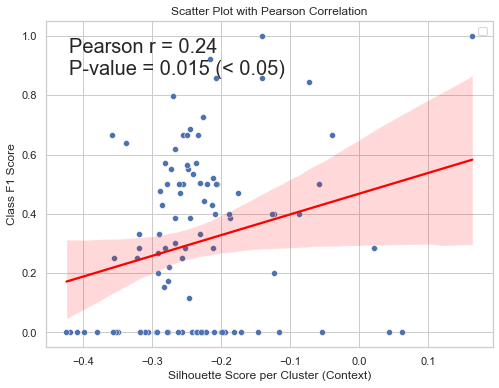

In [30]:
# Set the style of seaborn
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")
corr, p_value = pearsonr(silhouette_per_cluster_context , class_f1)
# Create the scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=silhouette_per_cluster_context, y=class_f1)

# Add a line of best fit
sns.regplot(x=silhouette_per_cluster_context, y=class_f1, scatter=False, color='red', line_kws={"label":f"Pearson r={corr:.2f}"})

# Add labels and title
plt.xlabel("Silhouette Score per Cluster (Context)")
plt.ylabel("Class F1 Score")
plt.title("Scatter Plot with Pearson Correlation")

plt.text(0.05, 0.95, f'Pearson r = {corr:.2f}\nP-value = {p_value:.3f} (< 0.05)',
         transform=plt.gca().transAxes,
         fontsize=20,
         verticalalignment='top')
# Display the legend with Pearson correlation
plt.legend()

# Show the plot
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


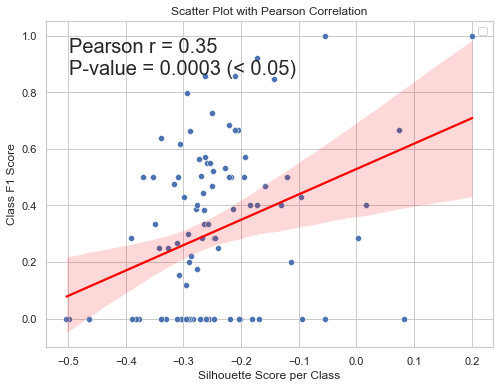

In [63]:
# Set the style of seaborn
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")
corr, p_value = pearsonr(silhouette_per_cluster_context , class_f1)
# Create the scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=silhouette_per_cluster_context, y=class_f1)

# Add a line of best fit
sns.regplot(x=silhouette_per_cluster_context, y=class_f1, scatter=False, color='red', line_kws={"label":f"Pearson r={corr:.2f}"})

# Add labels and title
plt.xlabel("Silhouette Score per Class")
plt.ylabel("Class F1 Score")
plt.title("Scatter Plot with Pearson Correlation")

plt.text(0.05, 0.95, f'Pearson r = {corr:.2f}\nP-value = {p_value:.4f} (< 0.05)',
         transform=plt.gca().transAxes,
         fontsize=20,
         verticalalignment='top')
# Display the legend with Pearson correlation
plt.legend()

# Show the plot
plt.show()

In [16]:
silhouette_values.shape

(1085,)

In [ ]:
from sklearn.metrics import silhouette_samples

def silhouette_score_per_cluster(embeddings, labels, metric="cosine"):
    sample_silhouette_values = silhouette_samples(embeddings, labels, metric=metric)

In [481]:
model = BertForMultiOutputClassification(ckpt_hp, device=device, lm=ckpt['hp'].lm, version=args.pool_version)
max_num_col = 1
dataset_cls = GittablesColwiseDataset
test_dataset = dataset_cls(cv=cv,
                            split="test",
                            tokenizer=tokenizer,
                            max_length=max_length,
                            device=device,
                            base_dirpath=os.path.join(args.data_path, "GitTables/semtab_gittables/2022"),
                            small_tag=args.small_tag,
                            max_num_col=max_num_col,
                            random_sample=False,
                            context_encoding_type="v1",
                            adaptive_max_length=False   )
test_dataloader = DataLoader(test_dataset,
                                batch_size=batch_size,
                                collate_fn=padder)   
padder = collate_fn(tokenizer.pad_token_id)
model.eval()
model = model.to(device)
labels_single = []
embeddings_single = []
with torch.no_grad():
    for batch_idx, batch in enumerate(test_dataloader):
        batch["data"] = batch["data"].to(device)
        cls_indexes = torch.nonzero(
                batch["data"].T == tokenizer.cls_token_id)
        logits, embs = model(batch["data"].T, cls_indexes=cls_indexes, get_enc=True)
        label = batch["label"].T.cpu()
        labels_single += label.numpy().tolist()
        embeddings_single.append(embs.cpu())
embeddings_single = torch.cat(embeddings_single, dim=0).numpy()
labels_single = np.array(labels_single)

A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Pl

test
test 1085


In [483]:
print(silhouette_score(embeddings_single, labels_single, metric='cosine'))
print(silhouette_score(embeddings_context, labels_single, metric='cosine'))
class_silhouette_score_context = np.array(silhouette_score_per_cluster(embeddings_context, labels_single))
class_silhouette_score = np.array(silhouette_score_per_cluster(embeddings_single, labels_single))

-0.43563807
-0.6391792


In [487]:
(labels_single == labels_context).mean()

1.0

In [484]:
from scipy.stats import pearsonr
pearsonr(class_silhouette_score, class_f1_single)

PearsonRResult(statistic=0.2650148932013318, pvalue=0.007400080820996573)

In [485]:
from scipy.stats import pearsonr
pearsonr(class_silhouette_score_context, class_f1)

PearsonRResult(statistic=-0.1094130262929831, pvalue=0.2760770829862365)

In [486]:
from scipy.stats import pearsonr
pearsonr(class_silhouette_score-class_silhouette_score_context, class_f1_single-class_f1)

PearsonRResult(statistic=0.07887601049393256, pvalue=0.43301087491856555)

In [459]:
from scipy.stats import pearsonr
pearsonr(class_silhouette_score-class_silhouette_score_context, class_f1_single-class_f1)

PearsonRResult(statistic=0.1245590867587209, pvalue=0.21458306305455738)

In [ ]:
from scipy.stats import pearsonr
pearsonr(class_silhouette_score, class_f1)

In [439]:
class_silhouette_score.argmax()

53

In [508]:
model = BertForMultiOutputClassification(ckpt_hp, device=device, lm=ckpt['hp'].lm, version=args.pool_version)
max_num_col = 8
dataset_cls = GittablesColwiseDataset
test_dataset = dataset_cls(cv=cv,
                            split="test",
                            tokenizer=tokenizer,
                            max_length=max_length,
                            device=device,
                            base_dirpath=os.path.join(args.data_path, "GitTables/semtab_gittables/2022"),
                            small_tag=args.small_tag,
                            max_num_col=max_num_col,
                            random_sample=False,
                            context_encoding_type="v1",
                            adaptive_max_length=False   )
test_dataloader = DataLoader(test_dataset,
                                batch_size=batch_size,
                                collate_fn=padder)   
padder = collate_fn(tokenizer.pad_token_id)
model.load_state_dict(torch.load(f"/data/zhihao/TU/Watchog/outputs/gt-semtab22-dbpedia-all{cv}/bert-base-uncased-fromscratch-semi1-pool@v0-context@v1-max_num_col@{max_num_col}-poolv0-max_cols{max_num_col}-randFalse-bs16-ml64-ne50-do0.1_best_f1_micro.pt", map_location=device))
model.eval()
model = model.to(device)
labels_context = []
embeddings_context = []
with torch.no_grad():
    for batch_idx, batch in enumerate(test_dataloader):
        embs = model.bert(batch["data"])[0].mean(0)
        label = batch["label"].T.cpu()
        labels_context += label.numpy().tolist()
        embeddings_context.append(embs.cpu())
embeddings_context = torch.cat(embeddings_context, dim=0).numpy()
labels_context = np.array(labels_context)

A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Pl

test
test 1085


/tmp/ipykernel_1864547/603674706.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"/data/zhihao/TU/Watchog/outputs/gt-semtab22-dbpedia-

In [510]:
print(silhouette_score(embeddings_context, labels_context, metric='cosine'))
class_silhouette_score_context = np.array(silhouette_score_per_cluster(embeddings_context, labels_context))

-0.5017945


In [511]:
from scipy.stats import pearsonr
pearsonr(class_silhouette_score_context, class_f1)

PearsonRResult(statistic=-0.08033003837833856, pvalue=0.4245515229336005)

In [499]:
import json
import numpy as np

# Function to load confusion matrix from JSON file
# with open("/data/zhihao/TU/doduo/eval/sato0_mosato_bert_bert-base-uncased-bs16-ml-32__sato0-1.00=sato0.json", 'r') as f:
#     results = json.load(f)
with open(f"/data/zhihao/TU/Watchog/outputs/gt-semtab22-dbpedia-all{cv}/bert-base-uncased-fromscratch-semi1-pool@v0-context@v1-max_num_col@8-poolv0-max_cols8-randFalse-bs16-ml64-ne50-do0.1_eval.json", 'r') as f:
    results = json.load(f)

# labels_train = np.array(results['train']['tr_true_list'])
# preds_train = np.array(results['train']['tr_pred_list'])
# class_f1_train = np.array(results['train']['tr_class_f1'])

labels = np.array(results['f1_micro']['true_list'])
preds = np.array(results['f1_micro']['pred_list'])
class_f1 = np.array(results['f1_micro']['ts_class_f1'])
assert len(labels) == len(df_test["class_id"][df_test["class_id"]>-1])

array([ 0,  1, 18, ..., 49, 44,  0])

In [504]:
logits = (labels==preds).astype(float)

In [512]:
sample_silhouette_values = silhouette_samples(embeddings_context, labels, metric="cosine")

PearsonRResult(statistic=-0.05649202308403836, pvalue=0.06286423310417999)

In [6]:
for i, (index, group_df) in enumerate(df_train.groupby("table_id")):
    break

In [55]:
res = group_df["data"].apply(lambda x: preprocess_text_bm25(x)).to_list()
print(group_df["data"])

2532    Wuthering Heights;Jane Eyre;The Raven;Eleonora...
2533    Wuthering Heights, Emily Brontë's only novel, ...
2534                                  101;107;150;150;170
2535                                     12;11;333;555;22
2536                          11.11;12.34;13.13;14.0;15.0
2537                                  GBP;GBP;USD;USD;EUR
2538                                       11;11;16;16;13
2539                                       EN;EN;EN;EN;EN
Name: data, dtype: object


In [56]:
res

['wuthering heights jane eyre raven eleonora catweazle',
 'wuthering heights emily brontë novel published 1847 pseudonym ellis bell written october 1845 june 1846 wuthering heights anne brontë agnes grey accepted publisher thomas newby success sister charlotte novel jane eyre emily death charlotte edited manuscript wuthering heights arranged edited version published posthumous second edition 1850 jane eyre ɛər originally published jane eyre autobiography novel english writer charlotte brontë published pen name currer bell 16 october 1847 smith elder co london first american edition published following year harper brothers new york primarily bildungsroman jane eyre follows experiences eponymous heroine including growth adulthood love mr rochester brooding master thornfield hall novel revolutionised prose fiction focus jane moral spiritual development told intimate first person narrative actions events coloured psychological intensity book contains elements social criticism strong sense 

In [44]:
from rank_bm25 import BM25Okapi
bm25 = BM25Okapi(res)

In [50]:
torch.tensor(bm25.get_scores(res[0])).argsort(descending=True, stable=True)

tensor([0, 1, 2, 3, 4, 5, 6, 7])

In [68]:
torch.tensor(bm25.get_scores(res[0])).argsort(descending=True, stable=True)[1:6].tolist()

[1, 2, 3, 4, 5]

In [71]:
group_df.iloc[torch.tensor(bm25.get_scores(res[0])).argsort(descending=True, stable=True)[1:6].tolist()]

,table_id,col_idx,class,class_id,data
2533,GitTables_150500,1,NaN,-1,"Wuthering Heights, Emily Brontë's only novel, ..."
2534,GitTables_150500,2,NaN,-1,101;107;150;150;170
2535,GitTables_150500,3,NaN,-1,12;11;333;555;22
2536,GitTables_150500,4,price,24,11.11;12.34;13.13;14.0;15.0
2537,GitTables_150500,5,NaN,-1,GBP;GBP;USD;USD;EUR


In [72]:
group_df.iloc[[2, 1, 3, 4, 5]]

,table_id,col_idx,class,class_id,data
2534,GitTables_150500,2,NaN,-1,101;107;150;150;170
2533,GitTables_150500,1,NaN,-1,"Wuthering Heights, Emily Brontë's only novel, ..."
2535,GitTables_150500,3,NaN,-1,12;11;333;555;22
2536,GitTables_150500,4,price,24,11.11;12.34;13.13;14.0;15.0
2537,GitTables_150500,5,NaN,-1,GBP;GBP;USD;USD;EUR


In [78]:
group_df["data"].loc[2534]

'101;107;150;150;170'

In [70]:
# Assuming `bm25.get_scores(res[0])` returns a score array and you want the top scores
sorted_indices = torch.tensor(bm25.get_scores(res[0])).argsort(descending=True, stable=True)[1:6].tolist()

# Pass the flat list of sorted indices to iloc
selected_rows = group_df.iloc[torch.tensor(bm25.get_scores(res[0])).argsort(descending=True, stable=True)[1:6].tolist()]

In [51]:
torch.tensor(bm25.get_scores(res[4])).argsort(descending=True, stable=True)

tensor([4, 6, 3, 0, 1, 2, 5, 7])

In [2]:
preprocess_text_bm25("won won won")

''

In [1]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer("all-mpnet-base-v2", cache_folder="/data/zhihao/TU/Watchog/sentence_transformers_cache")

/home/zhihao/jupyterprojects/jupyter/lib/python3.8/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [2]:
embeddings = 

In [11]:
model.tokenize("won won won")['input_ids']

tensor([[   0, 1063,    2],
        [   0, 1055,    2],
        [   0, 1054,    2],
        [   0,    2,    1],
        [   0, 1063,    2],
        [   0, 1055,    2],
        [   0, 1054,    2],
        [   0,    2,    1],
        [   0, 1063,    2],
        [   0, 1055,    2],
        [   0, 1054,    2]])

In [12]:
model.tokenizer

MPNetTokenizerFast(name_or_path='sentence-transformers/all-mpnet-base-v2', vocab_size=30527, model_max_length=384, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '[UNK]', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	3: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	104: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	30526: AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, norm

In [15]:

model.tokenize(["<pad>"*512])

{'input_ids': tensor([[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
   

In [17]:

model.encode(["<pad>"*512,"<pad>"*512 ]).shape

(2, 768)

In [1]:
import string
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

# Load NLTK resources
import nltk
nltk.download('punkt')
nltk.download('stopwords')
text = "BM25 is a ranking function used in information retrieval. It's effective for search engines!"
def preprocess_text_bm25(text):
    # Lowercase the text
    text = text.lower()

    # Remove punctuation
    # Create a translation table where all punctuation is replaced with spaces
    translation_table = str.maketrans(string.punctuation, ' ' * len(string.punctuation))

    # Replace all punctuation in the text with spaces
    text = text.translate(translation_table)
    # print(text)

    # Tokenize the text
    tokens = text.split()
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    processed_text = ' '.join(tokens)
    return processed_text

# Example text
for text in group_df["data"].values:
    preprocessed_text = preprocess_text_bm25(text)
    print(preprocessed_text)
    print('************************************')

[nltk_data] Downloading package punkt to /home/zhihao/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/zhihao/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


NameError: name 'group_df' is not defined

In [19]:
import re
def remove_punctuation(text):
    text = text.replace("-", " ")
    text = text.replace(",", " ")
    text = text.replace(".", "")
    text = text.replace("(", " ")
    text = text.replace(")", " ")
    text = re.sub(r' +', ' ', text)
    return text

In [29]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'